# 기본 셋팅

In [35]:
# 라이브러리 import
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from datetime import datetime
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [36]:
# 구글 드라이브에 연동하여 데이터셋 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
os.chdir("/content/drive/MyDrive/exa_data")
os.getcwd()

# 경로 지정
df = pd.read_csv('online_commerce_data.csv', sep=",")

In [38]:
# 한글 폰트 출력
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# 전처리

## 결측치 제거

In [39]:
df.head()

,customer_no,age,gender,order_no,order_date,channel,item_category,item_code,item_name,price,qty,order_amount,discount_amount,paid_amount
0,2021059651101,68.0,9,202106072433746,2021/06/07,TV,캐쥬얼,323421750,밴딩팬츠,49900,1,49900,4990,44910
1,2018069800502,49.0,2,202105311957155,2021/05/31,TV,레포츠패션,323516657,트랙수트,39000,1,39000,1000,38000
2,2019073300103,35.0,1,202105138020462,2021/05/13,TV,뷰티,323393459,기초세트,72000,2,144000,27600,116400
3,2020075283364,41.0,9,202106171444319,2021/06/17,TV,건강식품,323420069,유산균,119000,2,238000,72920,165080
4,2020104780765,46.0,1,202106024431989,2021/06/02,TV,일반식품,321820178,건강주스,45900,1,45900,2290,43610


In [40]:
df.shape

(147311, 14)

In [41]:
# 결측치 확인
df.isnull().sum()

customer_no         0
age                38
gender              0
order_no            0
order_date          0
channel             0
item_category       0
item_code           0
item_name           0
price               0
qty                 0
order_amount        0
discount_amount     0
paid_amount         0
dtype: int64

age(나이)에 결측치가 존재하는 것을 알 수 있다.

해당 결측치는 평균 나이로 대체하여 결측치 제거


In [42]:
# 평균 나이 계산
mean_age = df['age'].mean()

# 결측치를 평균 나이로 대체
df['age'].fillna(mean_age, inplace=True)

In [43]:
df.isnull().sum()

customer_no        0
age                0
gender             0
order_no           0
order_date         0
channel            0
item_category      0
item_code          0
item_name          0
price              0
qty                0
order_amount       0
discount_amount    0
paid_amount        0
dtype: int64

## 가입시기 데이터 컬럼 만들기

In [44]:
# 'customer_no' 열에서 처음 6개의 숫자를 추출하여 '가입연월' 열에 저장
df['가입연월'] = df['customer_no'].astype(str).str[:6]

# 'customer_no' 열에서 6번째 이후의 숫자를 추출하여 'customer_no' 열에 저장
df['customer_no'] = df['customer_no'].astype(str).str[6:].astype(int)

## order_no에 저장되어 있는 중복 데이터(order_date) 제거



In [45]:
for index, row in df.iterrows():
    # order_date에서 '/' 기호 제거
    order_date = str(row['order_date']).replace('/', '')
    order_no = str(row['order_no'])
    # order_no에 저장되어있는 order_date데이터 삭제
    pattern = re.escape(order_date)
    df.at[index, 'order_no'] = re.sub(pattern=pattern, repl='', string=order_no)

## datetime으로 변환

In [46]:
# order_date 컬럼에 저장된 데이터 형식을 %Y/%m/%d 에서 %Y-%m-%d로 변환
def object_to_datetime(date_str):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    new_date_str = date_obj.strftime('%Y-%m-%d')
    return new_date_str

# 'order_date' 데이터를 datetime 형식으로 변경
df['order_date'] = df['order_date'].apply(object_to_datetime)
df['order_date'] = pd.to_datetime(df['order_date'])

# 가입연월을 datetime 형식으로 변경
df['가입연월'] = pd.to_datetime(df['가입연월'], format='%Y%m')

## 성별 데이터 처리
성별을 알 수 없지만 여성의류를 구매한 적이 있으면 여성, 남성의류를 구매한 적이 있으면 남성으로 저장

In [47]:
# 성별을 알 수 없지만 남성의류를 구매한적이 있으면 남성으로 분류
df.loc[(df['gender'] == 9) & (df['item_category'] == '남성의류'), 'gender'] = 1

# 성별을 알 수 없지만 여성의류를 구매한적이 있으면 여성으로 분류
df.loc[(df['gender'] == 9) & (df['item_category'] == '여성의류'), 'gender'] = 2

In [48]:
# 성별 데이터를 숫자가 아닌 문자로 처리
df.loc[(df['gender'] == 1), 'gender'] = '남성'
df.loc[(df['gender'] == 2), 'gender'] = '여성'
df.loc[(df['gender'] == 9), 'gender'] = '불명'

## 할인 퍼센트 컬럼 생성

In [49]:
# 할인율 = (할인 금액 / 구매액) * 100
df['할인율'] = (df['discount_amount'] / df['order_amount'] * 100).round(2)

데이터의 할인 금액과 구매 금액을 통해 할인율을 계산해보려 했는데 할인율이 소수점까지 계산되는 경우가 존재했다.

- 0번째 데이터의 경우 = 10%할인 쿠폰을 적용 했다고 볼 수 있다
- 1번째 데이터의 경우 = 1000원 할인 쿠폰을 적용 했다고 볼 수 있다.
- 3번째 데이터의 경우 = %할인 쿠폰도 1000원 같은 딱 맞아떨어지는 할인이 아니다 따라서 이는 쿠폰과 마일리지를 통해 할인을 받은 것 같았지만 TV를 통해 구매했는데 마일리지가 존재할까?

## 이상치 처리

In [50]:
df['age'].value_counts().sort_index().tail(20)

age
83.0      95
84.0     116
85.0      72
86.0      49
87.0      65
88.0      36
89.0      18
90.0      16
91.0      19
92.0      14
93.0       6
94.0       2
95.0      11
96.0       2
97.0       3
102.0     11
122.0      1
143.0      6
148.0      1
149.0      7
Name: count, dtype: int64

현재 인간의 최대 장수 나이는 119세인데 120세가 넘어가는 고객 데이터가 존재한다

In [51]:
# 나이가 120 이상인 행 선택하여 삭제
df = df[df['age'] < 120]

# EDA

## 상품 카테고리 분류

In [52]:
# 상품 카테고리 확인하기
df['item_category'].value_counts().index

Index(['일반식품', '레포츠패션', '생활용품', '언더웨어', '건강식품', '패션잡화', '뷰티', '여성의류', '대형가전',
       '생활가전', '캐쥬얼', '주방용품', '주방가전', '키즈/유아동', '레저/스포츠', '가구/인테리어', '상품권',
       '침구', '남성의류', '반려용품', '여행'],
      dtype='object', name='item_category')

In [53]:
df.columns

Index(['customer_no', 'age', 'gender', 'order_no', 'order_date', 'channel',
       'item_category', 'item_code', 'item_name', 'price', 'qty',
       'order_amount', 'discount_amount', 'paid_amount', '가입연월', '할인율'],
      dtype='object')

In [54]:
df['gender'].value_counts()

gender
여성    80364
남성    42556
불명    24376
Name: count, dtype: int64

In [55]:
df['channel'].value_counts()

channel
Mobile    84402
TV        62894
Name: count, dtype: int64

In [56]:
df['order_date'].value_counts().sort_index()

order_date
2021-01-01     301
2021-01-02     276
2021-01-03     217
2021-01-04     166
2021-01-05     213
              ... 
2021-06-20     875
2021-06-21     918
2021-06-22     961
2021-06-23    1369
2021-06-24    1393
Name: count, Length: 175, dtype: int64

In [57]:
df.columns

Index(['customer_no', 'age', 'gender', 'order_no', 'order_date', 'channel',
       'item_category', 'item_code', 'item_name', 'price', 'qty',
       'order_amount', 'discount_amount', 'paid_amount', '가입연월', '할인율'],
      dtype='object')

## 모바일 데이터셋과 TV데이터셋 만들기

In [58]:
# TV로 구매한 데이터
tv_df = df[df['channel']== 'TV'].copy()
# 모바일로 구매한 데이터
mobile_df = df[df['channel']== 'Mobile'].copy()

## 2021이전에 가입하고 2021이후 재구매한 사람들의 수

In [59]:
df_filtered = df[df['가입연월'] < '2021-01'].groupby('customer_no').count()
a = df_filtered['가입연월'].sum(axis=0)

In [60]:
df_filtered = df.groupby('customer_no').count()
b = df_filtered['가입연월'].sum(axis=0)

In [61]:
print(f'총 고객들 수 : {b}')
print(f'2015년 부터 2021 전에 회원가입한 기존 고객들 수 : {a}')
print(f'2021 이후에 회원가입한 신규 고객들 수 : {b-a}')

총 고객들 수 : 147296
2015년 부터 2021 전에 회원가입한 기존 고객들 수 : 122828
2021 이후에 회원가입한 신규 고객들 수 : 24468


## 월별 가입자 수 동향 파악 시각화

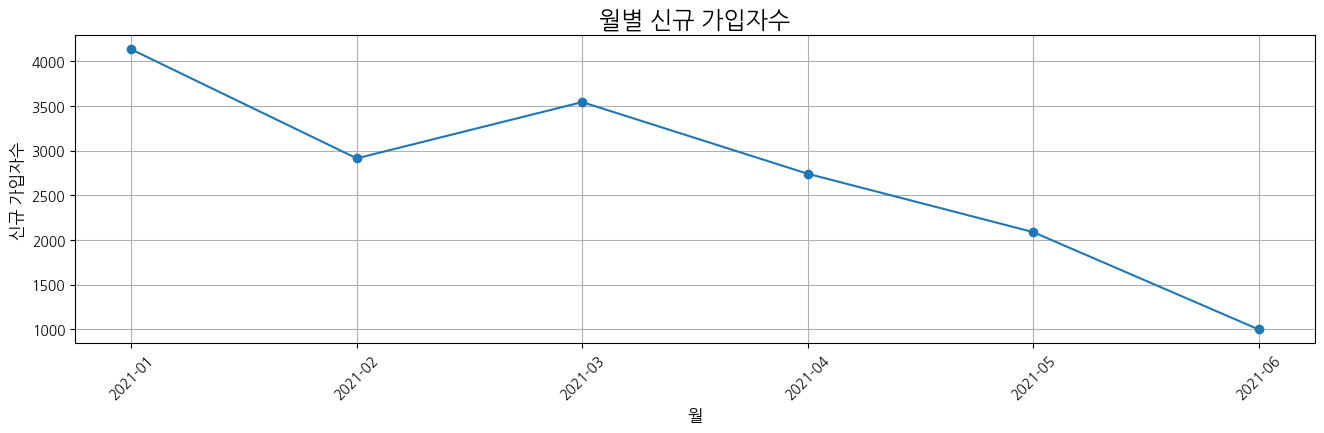

In [62]:
# 월별 신규 가입자 수 시각화
group_df = df[df['가입연월'] >= '2021-01'].groupby('가입연월')['customer_no'].nunique()

# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(group_df.index.astype(str), group_df.values, marker='o')
plt.title('월별 신규 가입자수', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('신규 가입자수', fontsize=12)
plt.xticks(group_df.index.astype(str), [x.strftime('%Y-%m') for x in group_df.index],rotation=45)
plt.grid(True)
plt.show()

### TV

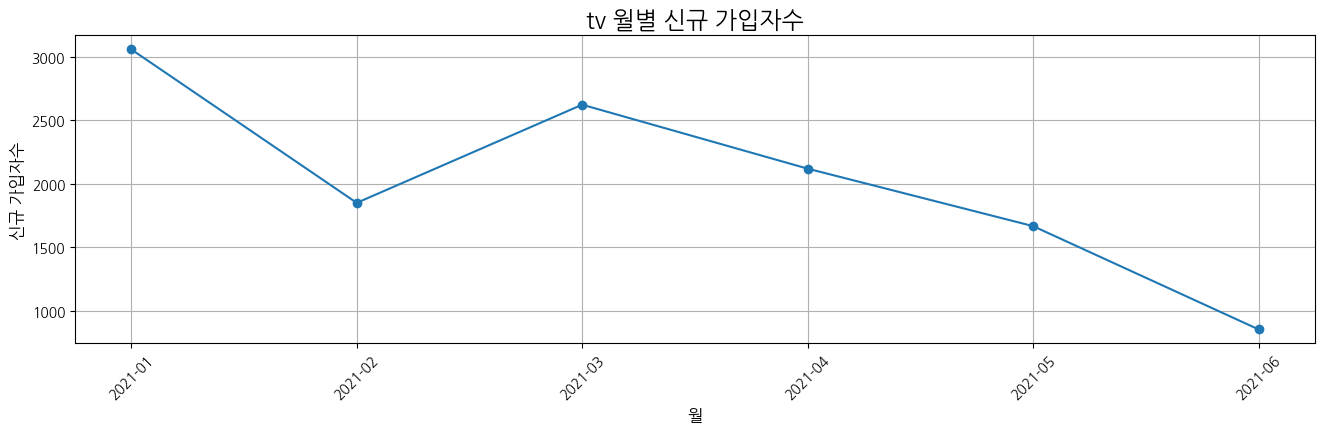

In [63]:
# 월별 신규 가입자 수 시각화
group_df = tv_df[tv_df['가입연월'] >= '2021-01'].groupby('가입연월')['customer_no'].nunique()

# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(group_df.index.astype(str), group_df.values, marker='o')
plt.title('tv 월별 신규 가입자수', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('신규 가입자수', fontsize=12)
plt.xticks(group_df.index.astype(str), [x.strftime('%Y-%m') for x in group_df.index],rotation=45)
plt.grid(True)
plt.show()

### 모바일

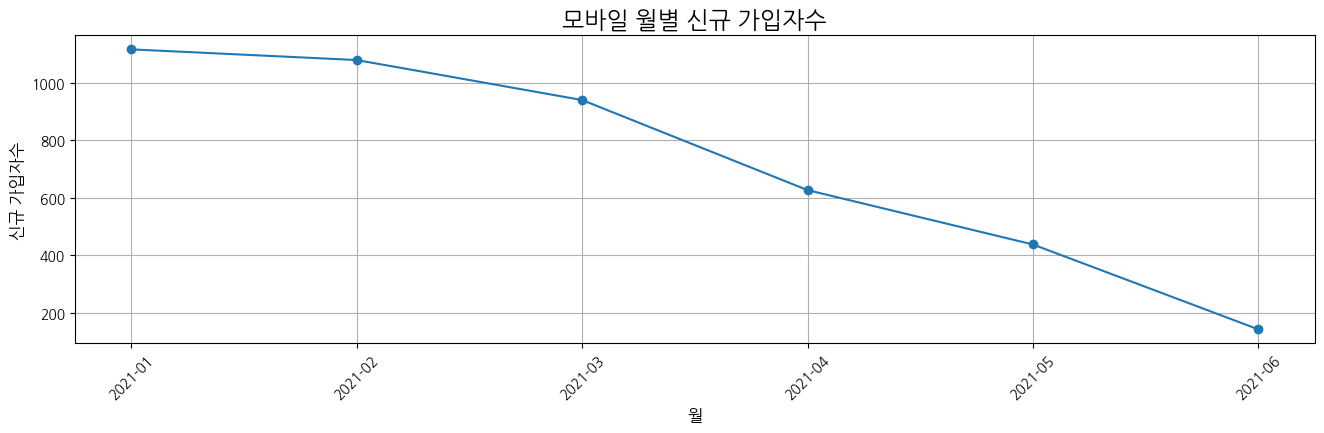

In [64]:
# 월별 신규 가입자 수 시각화
group_df = mobile_df[mobile_df['가입연월'] >= '2021-01'].groupby('가입연월')['customer_no'].nunique()

# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(group_df.index.astype(str), group_df.values, marker='o')
plt.title('모바일 월별 신규 가입자수', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('신규 가입자수', fontsize=12)
plt.xticks(group_df.index.astype(str), [x.strftime('%Y-%m') for x in group_df.index],rotation=45)
plt.grid(True)
plt.show()

## cohort차트로 총 고객의 고객 재구매율 시각화

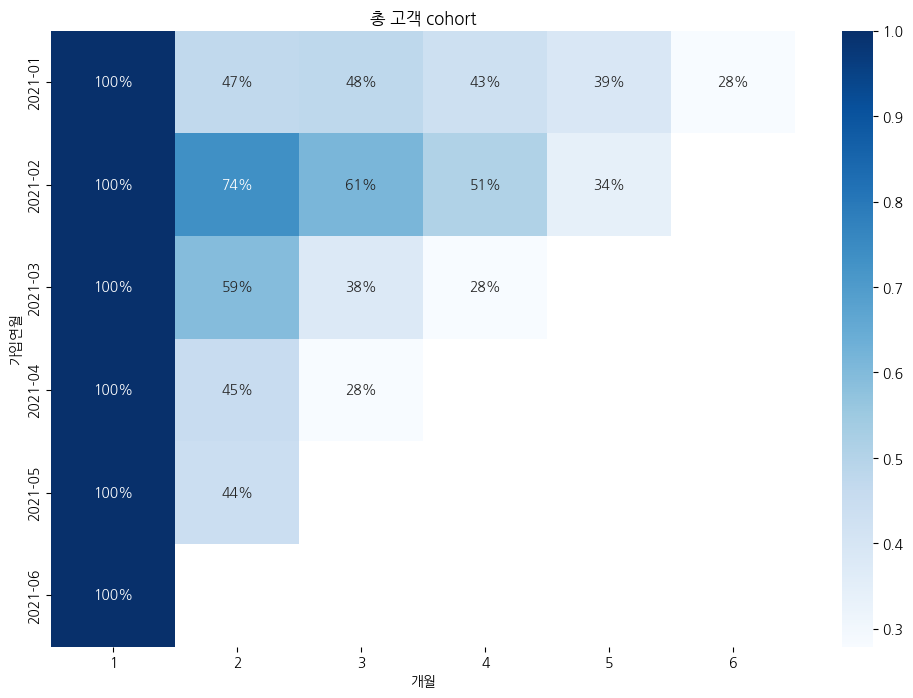

In [65]:
# 'order_date'와 '가입연월'에서 연월 정보만 추출하여 새로운 컬럼 생성
df['order_month'] = df['order_date'].dt.to_period('M')
df['가입연월'] = df['가입연월'].dt.to_period('M')

# 2021년 이후에 가입한 고객들의 데이터만 필터링
df_filtered = df[df['가입연월'] >= '2021-01']

# 고객이 첫 구매를 한 월('가입연월')과 구매한 월(order_month)의 차이(기간)를 계산하여 재구매 기간 컬럼 생성
def cohort_index(df):
    df['재구매기간'] = ((df['order_month'] - df['가입연월']).apply(lambda x: x.n)) + 1
    return df

df_filtered = df_filtered.groupby('customer_no').apply(cohort_index)

# 코호트별 사용자 수 계산
cohort_data = df_filtered.groupby(['가입연월', '재구매기간']).agg(n_customers=('customer_no', 'nunique')).reset_index()

# 코호트별 첫 달 사용자 수로 나누어 retention 계산
cohort_counts = cohort_data.pivot(index='가입연월', columns='재구매기간', values='n_customers')
base = cohort_counts[1]
retention = cohort_counts.divide(base, axis=0).round(3)

# 코호트 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('총 고객 cohort')
plt.ylabel('가입연월')
plt.xlabel('개월')
plt.show()

2월에 가입한 고객들의 재구매율은 74%로 높은 재구매율을 가지고 있다

하지만 2월 이후에 가입한 고객들의 경우 재구매율이 점점 감소하는 경향을 띄우고 있다.

### TV cohort

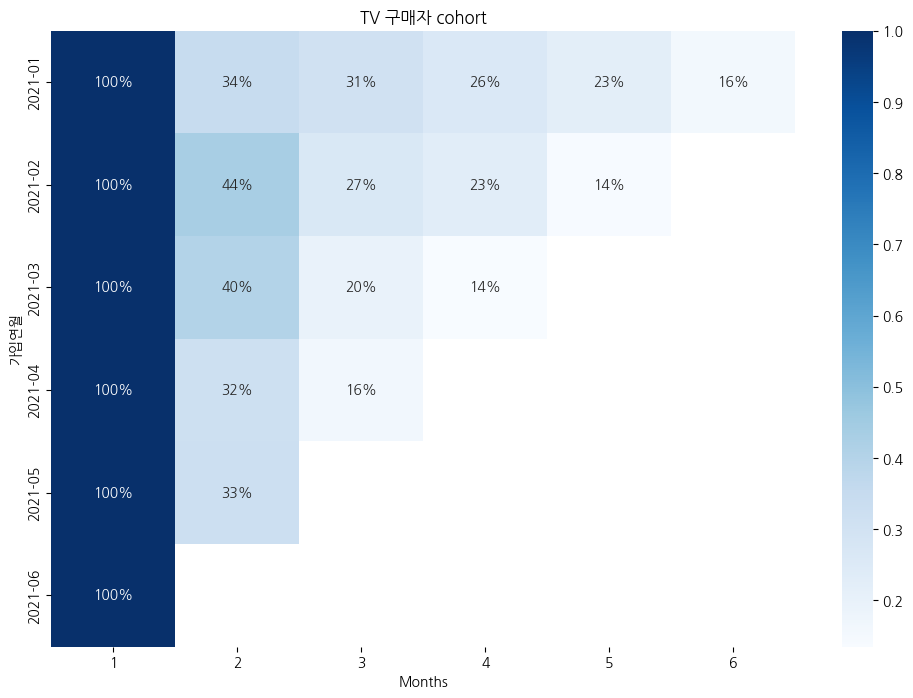

In [66]:
# 'order_date'와 '가입연월'에서 연월 정보만 추출하여 새로운 컬럼 생성
tv_df['order_month'] = tv_df['order_date'].dt.to_period('M')
tv_df['가입연월'] = tv_df['가입연월'].dt.to_period('M')

# 2021년 이후에 가입한 고객들의 데이터만 필터링
tv_df_filtered = tv_df[tv_df['가입연월'] >= '2021-01']
tv_df_filtered = tv_df_filtered.groupby('customer_no').apply(cohort_index)

# 코호트별 사용자 수 계산
cohort_data = tv_df_filtered.groupby(['가입연월', '재구매기간']).agg(n_customers=('customer_no', 'nunique')).reset_index()

# 코호트별 첫 달 사용자 수로 나누어 retention 계산
cohort_counts = cohort_data.pivot(index='가입연월', columns='재구매기간', values='n_customers')
base = cohort_counts[1]
retention = cohort_counts.divide(base, axis=0).round(3)

# 코호트 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('TV 구매자 cohort')
plt.ylabel('가입연월')
plt.xlabel('Months')
plt.show()

### 모바일 cohort

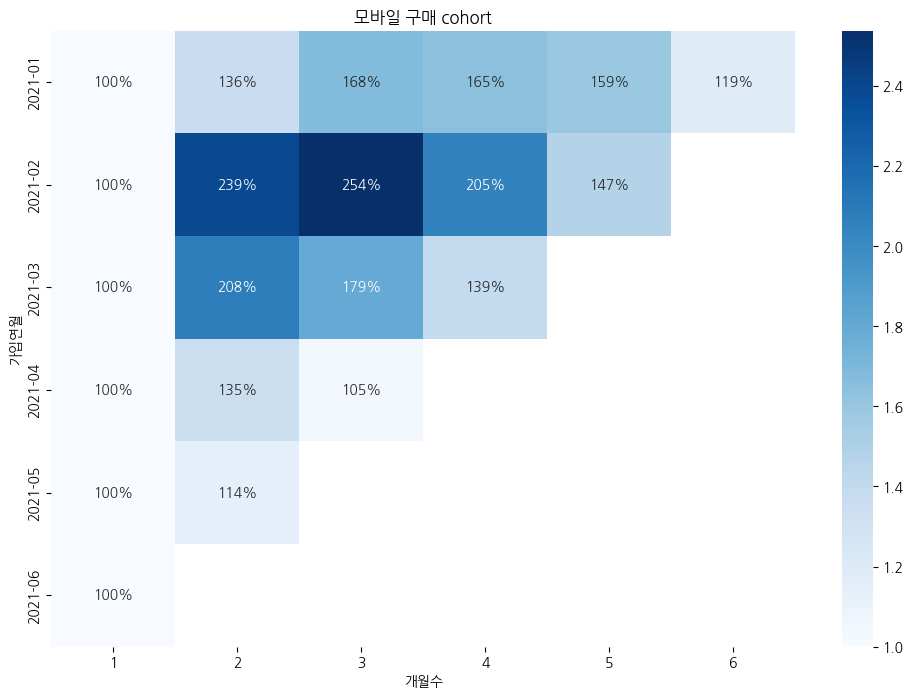

In [67]:
# 'order_date'와 '가입연월'에서 연월 정보만 추출하여 새로운 컬럼 생성
mobile_df['order_month'] = mobile_df['order_date'].dt.to_period('M')
mobile_df['가입연월'] = mobile_df['가입연월'].dt.to_period('M')

# 2021년 이후에 가입한 고객들의 데이터만 필터링
mobile_df_filtered = mobile_df[mobile_df['가입연월'] >= '2021-01']
mobile_df_filtered = mobile_df_filtered.groupby('customer_no').apply(cohort_index)

# 코호트별 사용자 수 계산
cohort_data = mobile_df_filtered.groupby(['가입연월', '재구매기간']).agg(n_customers=('customer_no', 'nunique')).reset_index()

# 코호트별 첫 달 사용자 수로 나누어 retention 계산
cohort_counts = cohort_data.pivot(index='가입연월', columns='재구매기간', values='n_customers')
base = cohort_counts[1]
retention = cohort_counts.divide(base, axis=0).round(3)

# 코호트 차트 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('모바일 구매 cohort')
plt.ylabel('가입연월')
plt.xlabel('개월수')
plt.show()

## 월별 총 매출액 그래프

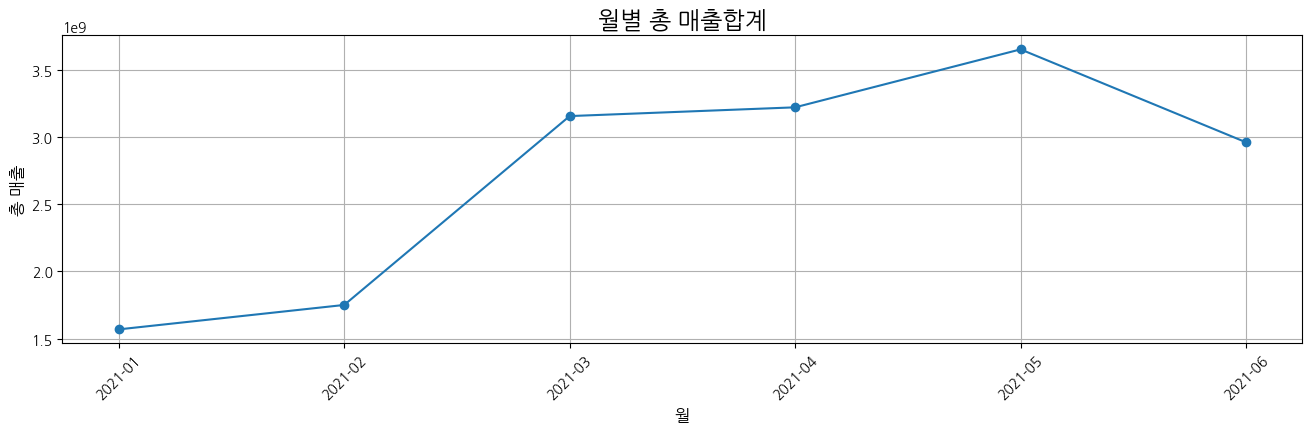

In [69]:
group_df = df.groupby('order_month')['paid_amount'].sum()

# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(group_df.index.astype(str), group_df, marker='o')
plt.title('월별 총 매출합계', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('총 매출', fontsize=12)
plt.xticks(group_df.index.astype(str), [x.strftime('%Y-%m') for x in group_df.index],rotation=45)
plt.grid(True)
plt.show()

### TV

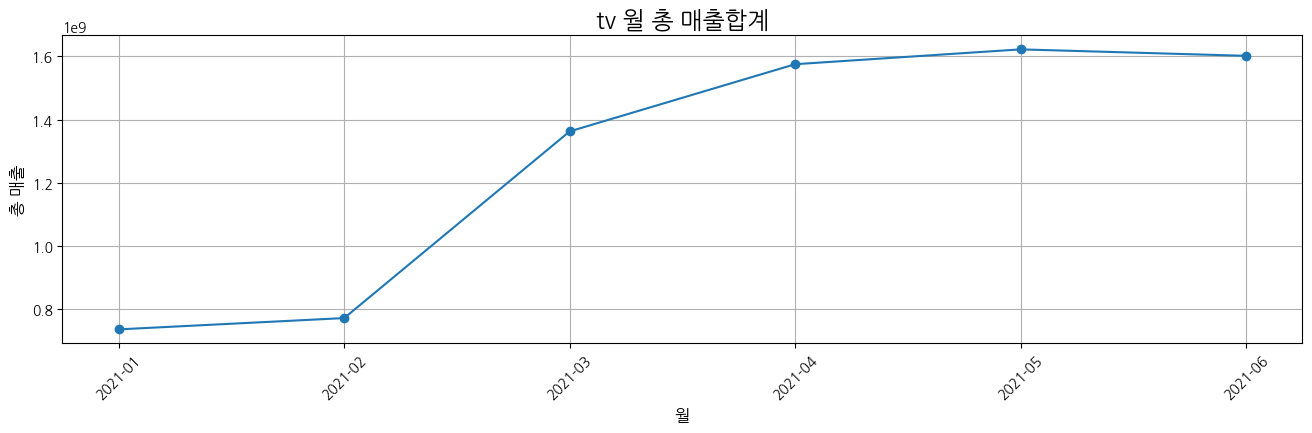

In [71]:
group_df = tv_df.groupby('order_month')['paid_amount'].sum()
# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(group_df.index.astype(str), group_df, marker='o')
plt.title('tv 월 총 매출합계', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('총 매출', fontsize=12)
plt.xticks(group_df.index.astype(str), [x.strftime('%Y-%m') for x in group_df.index],rotation=45)
plt.grid(True)
plt.show()

### mobile

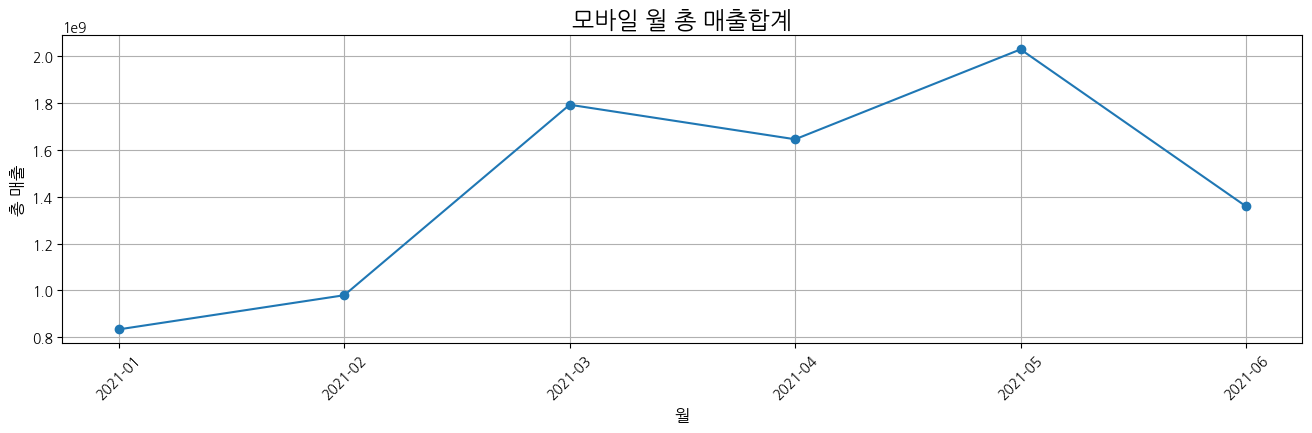

In [70]:
group_df = mobile_df.groupby('order_month')['paid_amount'].sum()
# 시간에 따른 매출 금액 시각화
plt.figure(figsize=(16, 4))
plt.plot(group_df.index.astype(str), group_df, marker='o')
plt.title('모바일 월 총 매출합계', fontsize=17)
plt.xlabel('월', fontsize=12)
plt.ylabel('총 매출', fontsize=12)
plt.xticks(group_df.index.astype(str), [x.strftime('%Y-%m') for x in group_df.index],rotation=45)
plt.grid(True)
plt.show()

## 모바일과 tv 판매 비율 확인하기

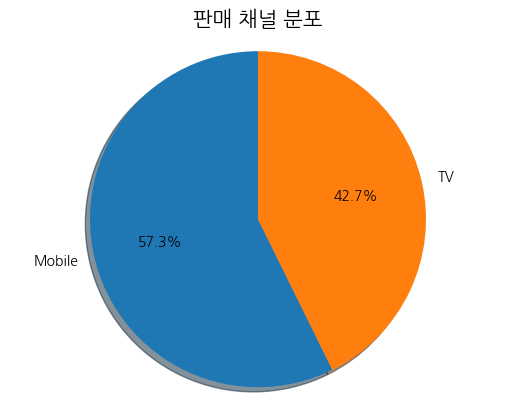

In [72]:
# 판매채널별 집계
pie_data = df['channel'].value_counts()

plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, shadow= True)
plt.title('판매 채널 분포', fontsize=15)
plt.axis('equal')  # 원형을 유지하기 위해 설정
plt.show()

tv보다 모바일을 이용하여 구매하는 고객들이 14.6% 더 많은 것을 알 수 있다.

## 구매 횟수에 따른 고객 비율 파악

In [73]:
# groupby로 구매횟수 파악하기
group_df = df.groupby('customer_no').count()

# 구매 횟수에 따라 고객 카테고리 분류하기
a = group_df[group_df['order_no']<2]['order_no'].count()
b = group_df[(group_df['order_no']>=2) & (group_df['order_no']<5)]['order_no'].count()
c = group_df[group_df['order_no']>5]['order_no'].count()
print(a,b,c)

50171 15670 4162


## 카테고리별 판매 수량 변동 그래프 시각화

In [74]:
df.columns

Index(['customer_no', 'age', 'gender', 'order_no', 'order_date', 'channel',
       'item_category', 'item_code', 'item_name', 'price', 'qty',
       'order_amount', 'discount_amount', 'paid_amount', '가입연월', '할인율',
       'order_month'],
      dtype='object')

In [75]:
df['item_category'].unique()

array(['캐쥬얼', '레포츠패션', '뷰티', '건강식품', '일반식품', '패션잡화', '대형가전', '언더웨어',
       '생활가전', '여성의류', '레저/스포츠', '생활용품', '주방가전', '키즈/유아동', '상품권', '주방용품',
       '침구', '가구/인테리어', '반려용품', '남성의류', '여행'], dtype=object)

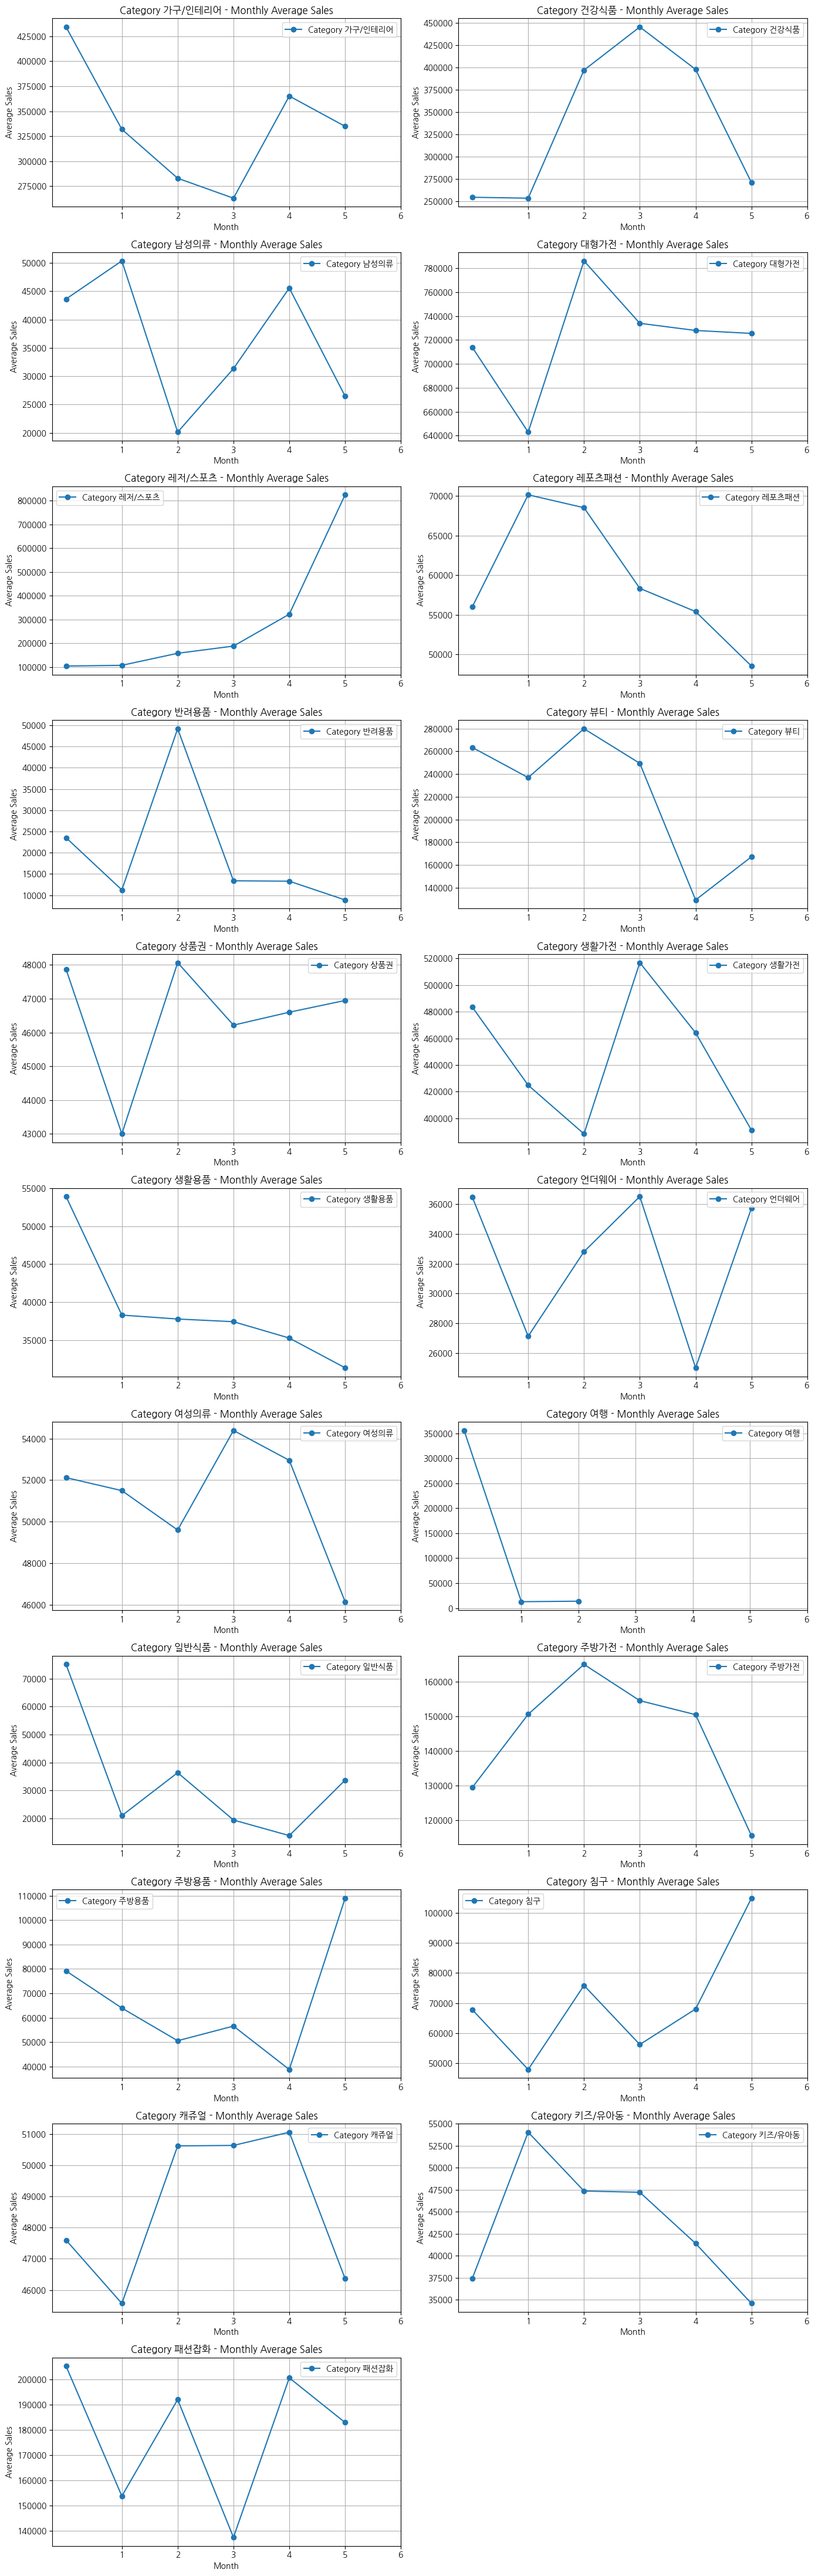

In [76]:
df_grouped = df.groupby(['item_category', 'order_month'])['paid_amount'].mean().reset_index()

# 카테고리별로 subplot 생성
categories = df_grouped['item_category'].unique()
n_categories = len(categories)

# subplot의 행 수 결정
rows = int(np.ceil(n_categories / 2))

plt.figure(figsize=(14, rows * 4))

for i, category in enumerate(categories, start=1):
    plt.subplot(rows, 2, i)
    df_category = df_grouped[df_grouped['item_category'] == category]
    plt.plot(df_category['order_month'].astype(str), df_category['paid_amount'], marker='o', linestyle='-', label=f'Category {category}')
    plt.title(f'Category {category} - Monthly Average Sales')
    plt.xlabel('Month')
    plt.ylabel('Average Sales')
    plt.xticks(ticks=np.arange(1, 7), labels=np.arange(1, 7))
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 카테고리별 할인율과 구매금액 시각화

In [78]:
df.columns

Index(['customer_no', 'age', 'gender', 'order_no', 'order_date', 'channel',
       'item_category', 'item_code', 'item_name', 'price', 'qty',
       'order_amount', 'discount_amount', 'paid_amount', '가입연월', '할인율',
       'order_month'],
      dtype='object')

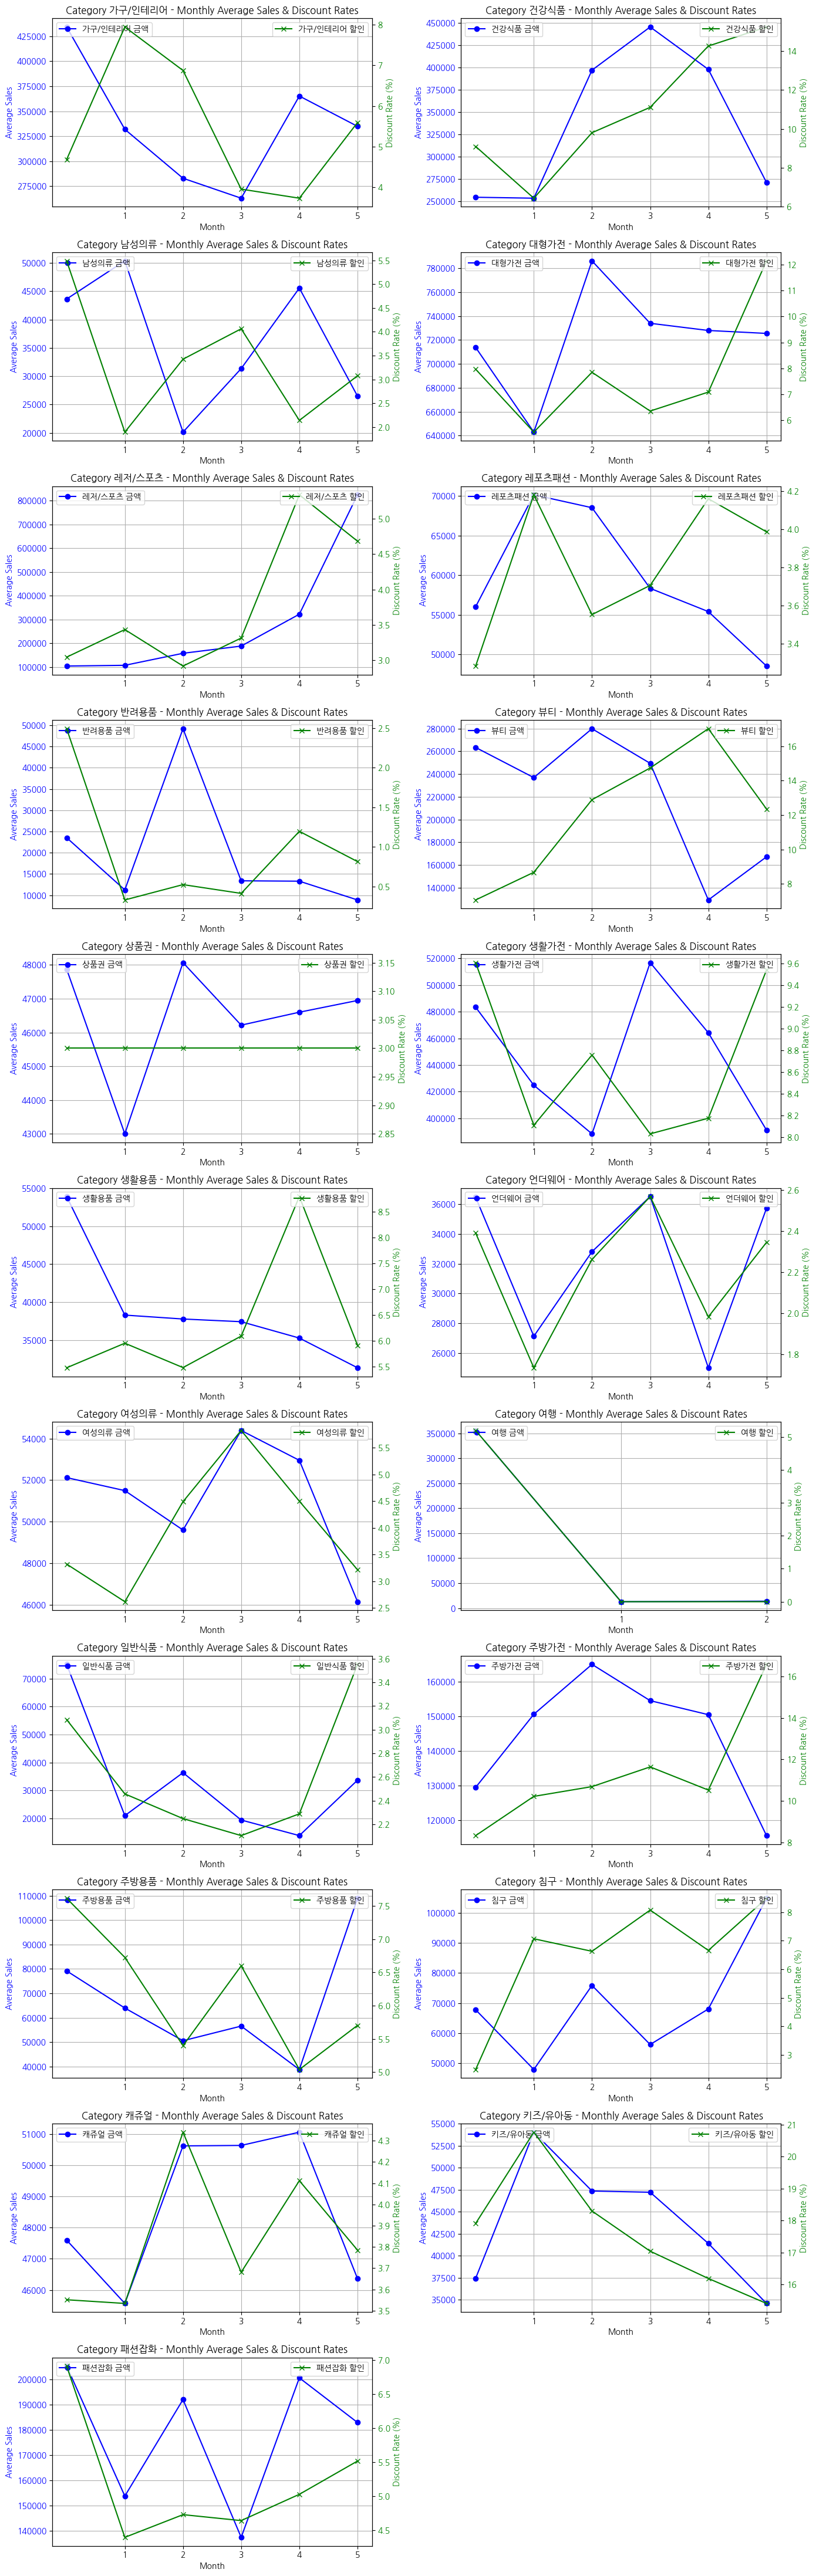

In [80]:
df_grouped = df.groupby(['item_category', 'order_month'])[['paid_amount','할인율']].mean().reset_index()

categories = df_grouped['item_category'].unique()
n_categories = len(categories)

rows = int(np.ceil(n_categories / 2))  # subplot의 행 수 결정

plt.figure(figsize=(14, rows * 4))

for i, category in enumerate(categories, start=1):
    ax1 = plt.subplot(rows, 2, i)
    df_category = df_grouped[df_grouped['item_category'] == category]

    # 매출액 그래프
    ax1.plot(df_category['order_month'].astype(str), df_category['paid_amount'], marker='o', linestyle='-', label=f'{category} 금액', color='b')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Sales', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xticks(ticks=np.arange(1, 7), labels=np.arange(1, 7))
    ax1.grid(True)

    # 할인율 그래프를 위한 이중 y축 생성
    ax2 = ax1.twinx()
    ax2.plot(df_category['order_month'].astype(str), df_category['할인율'], marker='x', linestyle='-', label=f'{category} 할인', color='g')
    ax2.set_ylabel('Discount Rate (%)', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # 각 그래프의 범례 설정
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'Category {category} - Monthly Average Sales & Discount Rates')

plt.tight_layout()
plt.show()

## 판매 채널별 할인율과 구매 금액 산포도

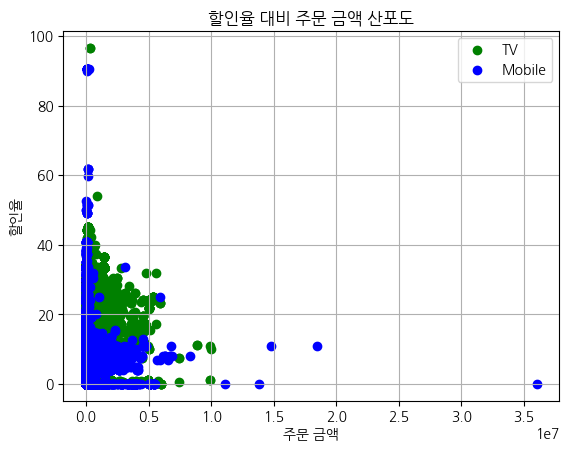

In [81]:
# TV 채널 데이터 필터링 및 산포도 그리기
plt.scatter(tv_df['order_amount'],tv_df['할인율'], color='green', label='TV')

# Mobile 채널 데이터 필터링 및 산포도 그리기
plt.scatter(mobile_df['order_amount'],mobile_df['할인율'],  color='blue', label='Mobile')

plt.title('할인율 대비 주문 금액 산포도')
plt.ylabel('할인율')
plt.xlabel('주문 금액')
plt.legend()
plt.grid(True)
plt.show()

조금 더 명확한 시각화를 위해 할인율이 높은 5개 데이터와 주문 금액이 높은 5개의 데이터는 제외

## 할인 받은 거래와 할인이 아닌 거래 빈도수를 월별로 비교

In [82]:
bins = [0,0.0001] + [x for x in range(5, 46, 5)] + [float('inf')]
bins

[0, 0.0001, 5, 10, 15, 20, 25, 30, 35, 40, 45, inf]

In [83]:
# 다음의 나일를 기준으로 구간을 나누고 할인구간이라는 파생 컬럼 생성
bins = [0,0.0001] + [x for x in range(5, 44, 5)] + [float('inf')]
labels = ['0', '1~5', '6~10', '11~15', '16~20', '21~25', '26~30', '31~35', '36~40', '41over' ]
df['할인구간'] = pd.cut(df['할인율'], bins=bins, labels=labels, right=False)

# 연령 구간별 집계
dis_count = df.groupby(['channel','할인구간'])['customer_no'].count().reset_index()

# gender 값을 컬럼으로 두고 customer_no 집계
pivot_table_result = dis_count.pivot_table(index='할인구간', columns='channel', values='customer_no', fill_value=0)

# pivot_table_result를 데이터프레임으로 변환
pivot_table_df = pd.DataFrame(pivot_table_result.to_records())

# 피라미드 차트로 나타내기 위한 데이터 전처리
dis = pivot_table_df['할인구간']
tv_data = pivot_table_df['TV']*-1
mobile_data = pivot_table_df['Mobile']

In [84]:
# Created figure
fig = go.Figure()

# Adding Female Data
fig.add_trace(go.Bar(x = tv_data,
                    y = dis,
                    name = 'tv',
                    orientation = 'h',
                    text = -1*tv_data))
# Adding Male Data
fig.add_trace(go.Bar(x = mobile_data,
                    y = dis,
                    name = '모바일',
                    orientation = 'h',
                    text = mobile_data))

# Updating the layout for our graph
fig.update_layout(title = '2021년 기준 할인율/거래 수 현황',
                 title_font_size = 19,
                 barmode = 'overlay',
                 bargap = 0.0,
                 bargroupgap = 0,
                 xaxis = dict(tickvals = [-60000, -40000, -20000, 0, 20000, 40000, 60000],
                             ticktext = ['6만번', '4만번', '2만번', '0', '2만번', '4만번', '6만번'],
                             title = '거래 성사 수',
                             title_font_size = 14))

fig.show()

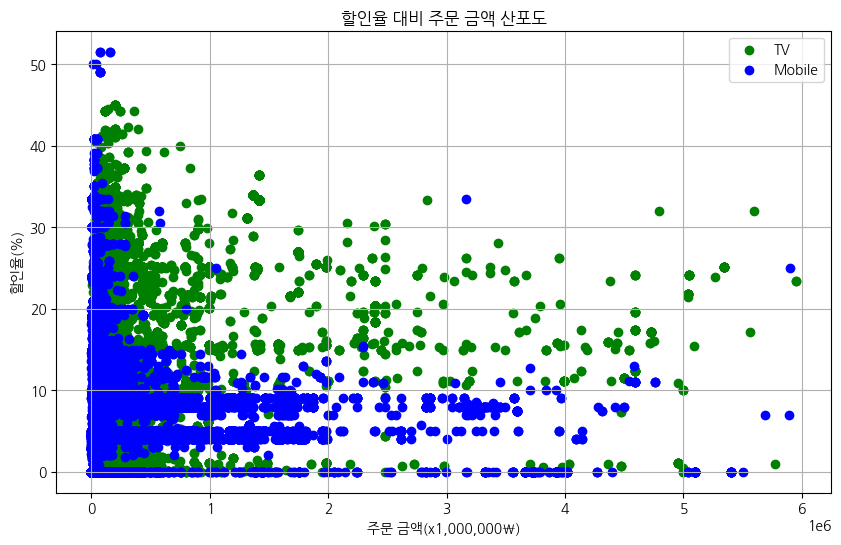

In [85]:
# 할인율과 주문 금액 기준으로 상위 30개 데이터 제외
discount_outliers = df['할인율'].nlargest(30).index
order_amount_outliers = df['order_amount'].nlargest(30).index

# 두 조건의 합집합을 이용해 제외할 인덱스 결정
outliers_index = discount_outliers.union(order_amount_outliers)

# 제외할 인덱스를 제외한 나머지 데이터 선택
filtered_df = df.drop(index=outliers_index)

# 채널별로 필터링된 데이터 시각화
channels = ['TV', 'Mobile']
colors = ['green', 'blue']

plt.figure(figsize=(10, 6))

for channel, color in zip(channels, colors):
    channel_data = filtered_df[filtered_df['channel'] == channel]
    plt.scatter(channel_data['order_amount'], channel_data['할인율'], color=color, label=channel)

plt.title('할인율 대비 주문 금액 산포도')
plt.ylabel('할인율(%)')
plt.xlabel('주문 금액(x1,000,000\)')
plt.legend()
plt.grid(True)
plt.show()

tv의 경우 할인이 높으면 더 높은 주문을 하는 경우가 많다

모바일의 경우 할인을 높게 해줘도 주문금액이 그만큼 증가하지 않는다

## 카테고리별 매출금액과 할인율 상관계수 출력

<ipython-input-86-25cfeddadf1e>:27: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



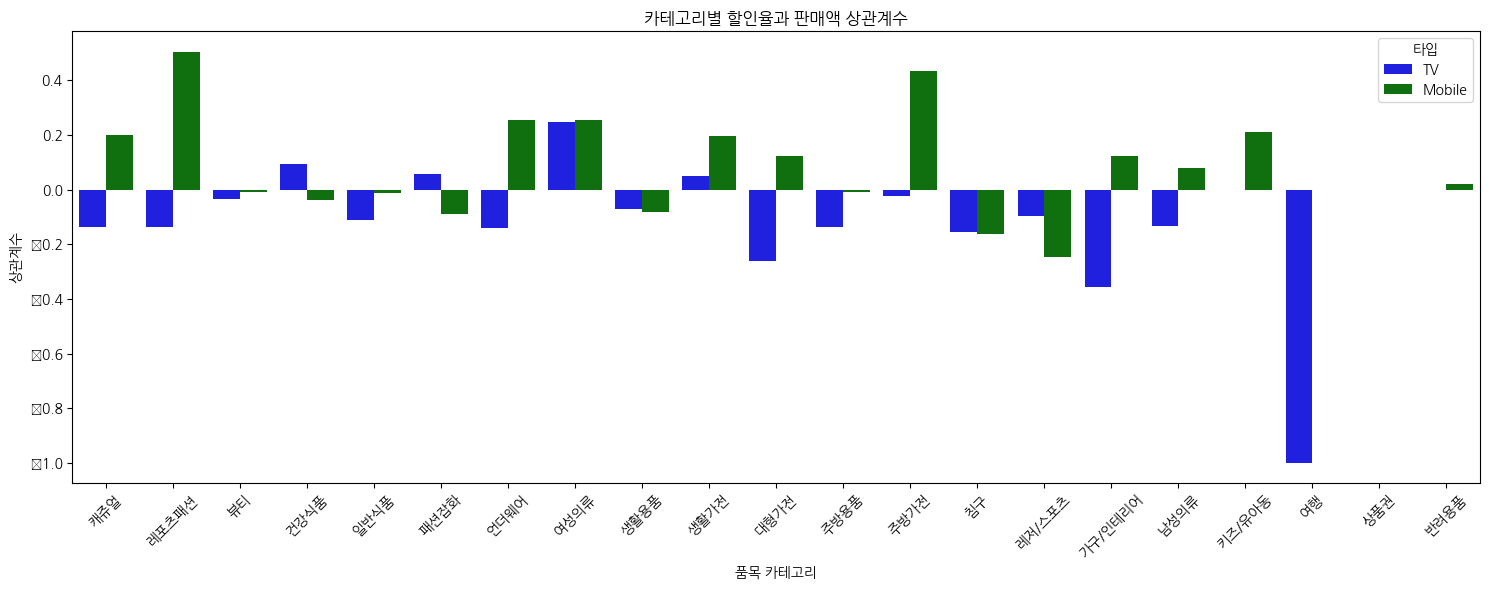

In [86]:
# 상관계수 데이터를 저장할 빈 데이터프레임 초기화
corr_df = pd.DataFrame(columns=['item_category', 'correlation', 'type'])

# 상관계수를 계산하고 저장하는 함수
def append_correlations(source_df, df_type, corr_df):
    for category in source_df['item_category'].unique():
        category_df = source_df[source_df['item_category'] == category]
        if not category_df.empty:
            corr = category_df[['할인율', 'paid_amount']].corr().iloc[0, 1]
            # append 대신 concat 사용
            new_row = pd.DataFrame({'item_category': [category], 'correlation': [corr], 'type': [df_type]})
            corr_df = pd.concat([corr_df, new_row], ignore_index=True)
    return corr_df

# TV와 Mobile 카테고리별 상관계수 계산 및 추가
corr_df = append_correlations(tv_df, 'TV', corr_df)
corr_df = append_correlations(mobile_df, 'Mobile', corr_df)

# 결과를 바 차트로 시각화
plt.figure(figsize=(15, 6))
sns.barplot(x='item_category', y='correlation', hue='type', data=corr_df, palette={'TV':'blue', 'Mobile':'green'})
plt.title('카테고리별 할인율과 판매액 상관계수')
plt.xlabel('품목 카테고리')
plt.ylabel('상관계수')
plt.xticks(rotation=45)
plt.legend(title='타입')
plt.tight_layout()
plt.show()

## 월별 평균 객단가 비교

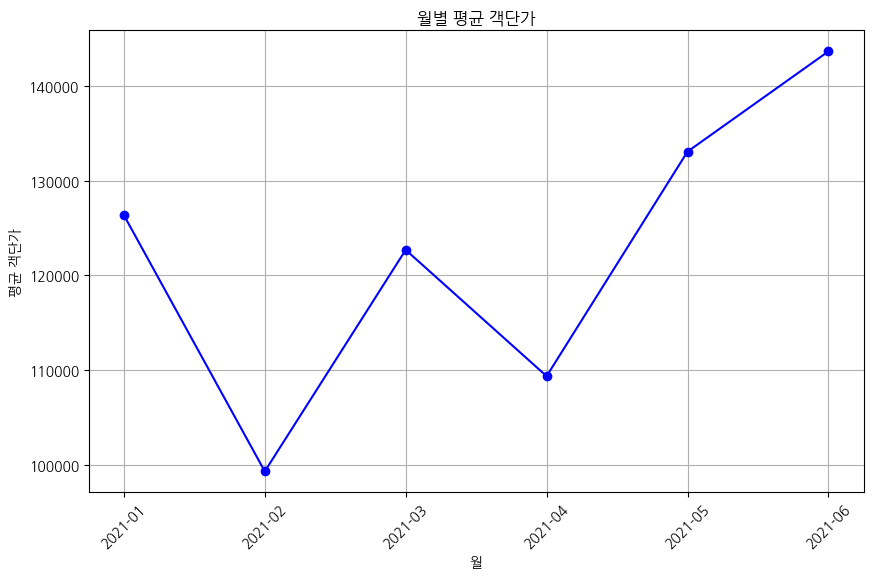

In [87]:
# 월별 총 매출과 주문 건수 집계
monthly_data = df.groupby('order_month').agg(total_sales=('order_amount', 'sum'), order_count=('order_amount', 'count'))

# 평균 객단가 계산
monthly_data['avg_order_value'] = monthly_data['total_sales'] / monthly_data['order_count']

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index.astype(str), monthly_data['avg_order_value'], marker='o', linestyle='-', color='blue')
plt.title('월별 평균 객단가')
plt.xlabel('월')
plt.ylabel('평균 객단가')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 대시보드 만들기

## 월별 신규 이용자수, cohort, 총매출

<ipython-input-89-2c7c7482479f>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-89-2c7c7482479f>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-89-2c7c7482479f>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



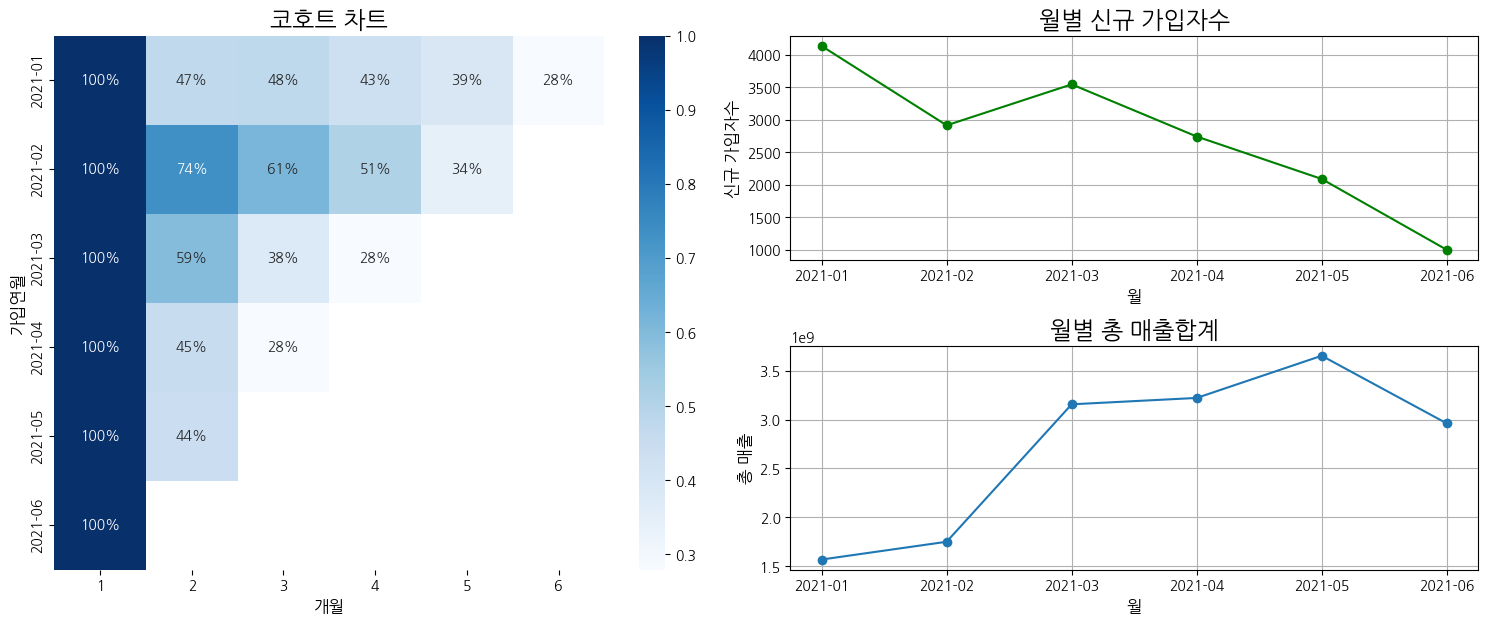

In [89]:
df['order_month'] = df['order_date'].dt.to_period('M')

# 대시보드 그림을 나타낼 크기 설정
fig = plt.figure(figsize=(15, 9))
gs = GridSpec(3, 6, figure=fig)

# 월별 신규 가입자 수 시각화
ax1 = fig.add_subplot(gs[0, 3:])
group_df = df[df['가입연월'] >= '2021-01'].groupby('가입연월')['customer_no'].nunique()
ax1.plot(group_df.index.astype(str), group_df.values, marker='o',color='g')
ax1.set_title('월별 신규 가입자수', fontsize=17)
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('신규 가입자수', fontsize=12)
ax1.set_xticklabels([x.strftime('%Y-%m') for x in group_df.index])
ax1.grid(True)

# 시간에 따른 매출 금액 시각화
ax2 = fig.add_subplot(gs[1, 3:])
group_df = df.groupby('order_month')['paid_amount'].sum()
ax2.plot(group_df.index.astype(str), group_df, marker='o')
ax2.set_title('월별 총 매출합계', fontsize=17)
ax2.set_xlabel('월', fontsize=12)
ax2.set_ylabel('총 매출', fontsize=12)
ax2.set_xticklabels([x.strftime('%Y-%m') for x in group_df.index])
ax2.grid(True)

# 코호트 분석을 통한 재구매 기간별 고객 유지율 시각화
df_filtered = df[df['가입연월'] >= '2021-01']
df_filtered['재구매기간'] = ((df_filtered['order_month'] - df_filtered['가입연월']).apply(lambda x: x.n)) + 1
cohort_data = df_filtered.groupby(['가입연월', '재구매기간']).agg(n_customers=('customer_no', 'nunique')).reset_index()
cohort_counts = cohort_data.pivot(index='가입연월', columns='재구매기간', values='n_customers')
base = cohort_counts[1]
retention = cohort_counts.divide(base, axis=0).round(3)

ax3 = fig.add_subplot(gs[0:2, :3])
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues', ax=ax3)
ax3.set_title('코호트 차트',fontsize=17)
ax3.set_ylabel('가입연월',fontsize=12)
ax3.set_xlabel('개월',fontsize=12)

plt.tight_layout()
plt.show()

## 채널별 매출액 비교

<ipython-input-91-653d65fd9259>:19: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-91-653d65fd9259>:29: UserWarning:

FixedFormatter should only be used together with FixedLocator



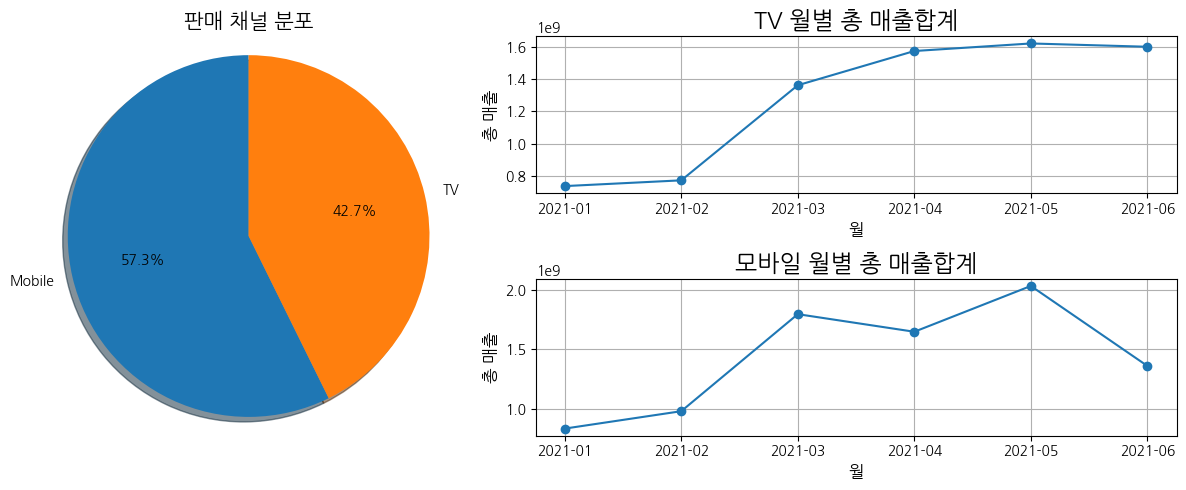

In [91]:
# 그림을 나타낼 크기 설정
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 5, figure=fig)

# 판매채널별 집계
pie_data = df['channel'].value_counts()
ax_pie = fig.add_subplot(gs[0:2, :2])
ax_pie.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, shadow=True)
ax_pie.set_title('판매 채널 분포', fontsize=15)
ax_pie.axis('equal') # 원형을 유지하기 위해 설정

# 첫 번째 그래프: tv 월별 매출합계 시각화
ax1 = fig.add_subplot(gs[0, 2:])
group_df = tv_df.groupby('order_month')['paid_amount'].sum()
ax1.plot(group_df.index.astype(str), group_df, marker='o')
ax1.set_title('TV 월별 총 매출합계', fontsize=17)
ax1.set_xlabel('월', fontsize=12)
ax1.set_ylabel('총 매출', fontsize=12)
ax1.set_xticklabels([x.strftime('%Y-%m') for x in group_df.index])
ax1.grid(True)

# 두 번째 그래프: 모바일 월별 매출합계 시각화
ax2 = fig.add_subplot(gs[1, 2:])
group_df = mobile_df.groupby('order_month')['paid_amount'].sum()
ax2.plot(group_df.index.astype(str), group_df, marker='o')
ax2.set_title('모바일 월별 총 매출합계', fontsize=17)
ax2.set_xlabel('월', fontsize=12)
ax2.set_ylabel('총 매출', fontsize=12)
ax2.set_xticklabels([x.strftime('%Y-%m') for x in group_df.index])
ax2.grid(True)

plt.tight_layout()
plt.show()

## 할인 거래 비율 파이차트, 산점도

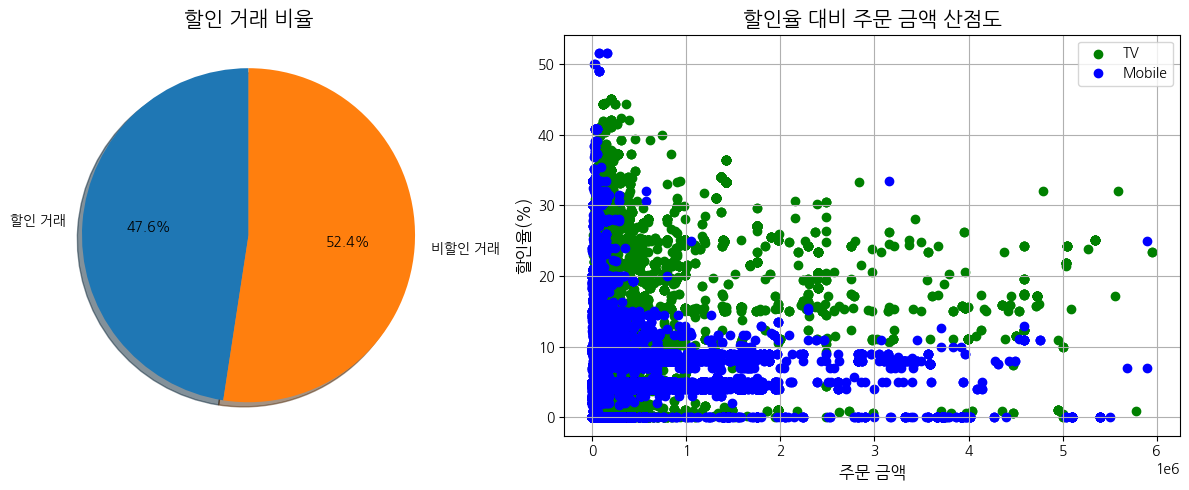

In [92]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 5, figure=fig)

# 판매채널별 집계를 위한 데이터 준비
discounted = len(df[df['할인율'] == 0])
not_discounted = len(df) - discounted
pie_data = [discounted, not_discounted]

# 할인 거래와 비할인 거래의 비율로 파이 차트 생성
ax_pie = fig.add_subplot(gs[0, :2])
ax_pie.pie(pie_data, labels=['할인 거래', '비할인 거래'], autopct='%1.1f%%', startangle=90, shadow=True)
ax_pie.set_title('할인 거래 비율', fontsize=15)
ax_pie.axis('equal')

# 할인율과 주문 금액 기준으로 상위 30개 데이터 제외
discount_outliers = df['할인율'].nlargest(30).index
order_amount_outliers = df['order_amount'].nlargest(30).index

# 두 조건의 합집합을 이용해 제외할 인덱스 결정
outliers_index = discount_outliers.union(order_amount_outliers)

# 제외할 인덱스를 제외한 나머지 데이터 선택
filtered_df = df.drop(index=outliers_index)

# 채널별로 필터링된 데이터 시각화
ax_scatter = fig.add_subplot(gs[0, 2:])
channels = ['TV', 'Mobile']
colors = ['green', 'blue']

for channel, color in zip(channels, colors):
    channel_data = filtered_df[filtered_df['channel'] == channel]
    ax_scatter.scatter(channel_data['order_amount'], channel_data['할인율'], color=color, label=channel)

plt.title('할인율 대비 주문 금액 산점도', fontsize=15)
plt.xlabel('주문 금액', fontsize=12)
plt.ylabel('할인율(%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [93]:
df[df['할인율'] == 0]

,customer_no,age,gender,order_no,order_date,channel,item_category,item_code,item_name,price,qty,order_amount,discount_amount,paid_amount,가입연월,할인율,order_month,할인구간
6,6102337,38.0,여성,1179298,2021-04-28,Mobile,일반식품,320105541,생수,5700,2,11400,0,11400,2020-01,0.0,2021-04,0
8,6797119,48.0,불명,5850988,2021-03-29,TV,일반식품,322670879,오렌지,39900,1,39900,0,39900,2021-03,0.0,2021-03,0
10,1890482,31.0,여성,8188869,2021-04-26,Mobile,일반식품,320105539,생수,3150,1,3150,0,3150,2019-02,0.0,2021-04,0
12,4989894,60.0,남성,9145752,2021-01-18,TV,레포츠패션,322397305,트랙수트,59000,1,59000,0,59000,2020-03,0.0,2021-01,0
13,1083135,46.0,여성,6391784,2021-02-28,Mobile,일반식품,322614618,생수,3300,1,3300,0,3300,2018-07,0.0,2021-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147303,6239175,32.0,남성,1710620,2021-05-31,Mobile,일반식품,320105539,생수,3260,1,3260,0,3260,2020-08,0.0,2021-05,0
147304,2761241,56.0,여성,2157188,2021-02-22,Mobile,일반식품,321043461,생수,6600,1,6600,0,6600,2020-06,0.0,2021-02,0
147305,2105193,41.0,여성,8867287,2021-05-20,Mobile,일반식품,321089035,건강음료,3500,1,3500,0,3500,2019-01,0.0,2021-05,0
147308,3044089,38.0,여성,6508012,2021-04-02,Mobile,일반식품,320105539,생수,3360,1,3360,0,3360,2019-08,0.0,2021-04,0


# 분석

## RFM

In [94]:
# 오늘 날짜 설정 (가장 최근의 주문일 이후의 날짜로 설정)
today = df['order_date'].max() + pd.Timedelta(days=1)

# RFM 지표 계산
rfm = df.groupby('customer_no').agg({
    'order_date': lambda x: (today - x.max()).days,
    'order_no': 'count',
    'paid_amount': 'sum'
}).rename(columns={'order_date': 'Recency',
                   'order_no': 'Frequency',
                   'paid_amount': 'Monetary'})

In [95]:
# RFM 지표에 따른 점수 할당 (qcut을 사용하여 동일한 수의 고객이 각 점수에 할당되도록 함)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'],5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# RFM 점수 결합
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm.head())

ValueError: Bin edges must be unique: array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.132e+03]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
# 고객 세그먼트 예시
top_customers = rfm[rfm['RFM_Score'] == '555']
print("최고 가치 고객 수:", len(top_customers))


In [ ]:
# OLS 모델을 사용하여 방문자 수에 대한 캠페인의 영향 분석
model = ols('order_amount ~ C(할인구간)', data=df).fit()

# ANOVA 테이블 생성
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

In [ ]:
# 데이터 준비
X = df[['할인율']]  # 독립 변수
y = df['order_amount']  # 종속 변수

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 릿지 회귀 모델 적합
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# 계수 및 성능 평가
print(f'계수: {ridge.coef_}')

In [ ]:
# 할인한 경우와 하지 않은 경우로 데이터 분리
a = mobile_df[mobile_df['할인율'] == 0]['order_amount']
b = mobile_df[mobile_df['할인율'] != 0]['order_amount']

# 만-휘트니 U 검정 수행
u_stat, p_val = mannwhitneyu(a, b)

print(f'U-통계량: {u_stat}, p-value: {p_val}')

In [ ]:
# 할인한 경우와 하지 않은 경우로 데이터 분리
a = mobile_df[mobile_df['할인율'] == 0]['order_amount']
b = mobile_df[mobile_df['할인율'] != 0]['order_amount']

# 만-휘트니 U 검정 수행
u_stat, p_val = mannwhitneyu(a, b)

print(f'U-통계량: {u_stat}, p-value: {p_val}')

## k-mean 클러스터링

In [100]:
# 필요한 패키지 설치 및 임포트
!pip install yellowbrick
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
# 고객 단위 아이템 카테고리별 구매 건수 합계
user_item_purchase = mobile_df.groupby(['customer_no', 'item_category'])['order_no'].nunique().reset_index()
user_item_purchase.head()

,customer_no,item_category,order_no
0,74,일반식품,1
1,113,일반식품,1
2,596,생활가전,1
3,652,일반식품,1
4,1152,일반식품,1


In [102]:
# pivot table 생성
purchase_info = user_item_purchase.pivot_table(index='customer_no', columns='item_category', values='order_no', fill_value=0)

# pivot table을 데이터프레임으로 변환
purchase_info = pd.DataFrame(purchase_info.to_records())

# customer_no 제거
purchase_info2 = purchase_info.drop('customer_no', axis = 1)

In [103]:
# 데이터 스케일 표준화
StandardScaler = StandardScaler()
df_standard = StandardScaler.fit_transform(purchase_info2)

# 컬럼명 결합
df_standard = pd.DataFrame(data=df_standard, columns=purchase_info2.columns)
df_standard.head()

,가구/인테리어,건강식품,남성의류,대형가전,레저/스포츠,레포츠패션,반려용품,뷰티,상품권,생활가전,...,언더웨어,여성의류,여행,일반식품,주방가전,주방용품,침구,캐쥬얼,키즈/유아동,패션잡화
0,-0.058267,-0.138593,-0.054501,-0.062562,-0.055612,-0.080954,-0.030597,-0.082201,-0.017729,-0.052168,...,-0.237608,-0.093304,-0.008555,-0.269722,-0.052722,-0.13699,-0.060326,-0.03786,-0.10247,-0.098053
1,-0.058267,-0.138593,-0.054501,-0.062562,-0.055612,-0.080954,-0.030597,-0.082201,-0.017729,-0.052168,...,-0.237608,-0.093304,-0.008555,-0.269722,-0.052722,-0.13699,-0.060326,-0.03786,-0.10247,-0.098053
2,-0.058267,-0.138593,-0.054501,-0.062562,-0.055612,-0.080954,-0.030597,-0.082201,-0.017729,0.303061,...,-0.237608,-0.093304,-0.008555,-0.529391,-0.052722,-0.13699,-0.060326,-0.03786,-0.10247,-0.098053
3,-0.058267,-0.138593,-0.054501,-0.062562,-0.055612,-0.080954,-0.030597,-0.082201,-0.017729,-0.052168,...,-0.237608,-0.093304,-0.008555,-0.269722,-0.052722,-0.13699,-0.060326,-0.03786,-0.10247,-0.098053
4,-0.058267,-0.138593,-0.054501,-0.062562,-0.055612,-0.080954,-0.030597,-0.082201,-0.017729,-0.052168,...,-0.237608,-0.093304,-0.008555,-0.269722,-0.052722,-0.13699,-0.060326,-0.03786,-0.10247,-0.098053


<ipython-input-104-f3c3db37bddd>:20: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



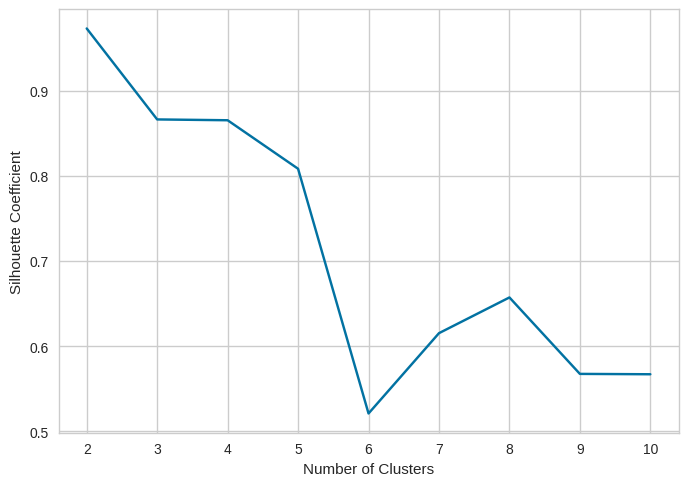

In [104]:
# 실루엣 계수 시각화 1

# k-means 모델 설정
kmeans_model_2 = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 37,
    }

# 각 K의 실루엣 계수 저장
silhouette_coef = []

# 실루엣 계수 그래프 생성
for k in range(2, 11):
    kmeans_silhouette = KMeans(n_clusters=k, **kmeans_model_2)
    kmeans_silhouette.fit(df_standard)
    score = silhouette_score(df_standard, kmeans_silhouette.labels_)
    silhouette_coef.append(score)
plt.style.use('seaborn-whitegrid')
plt.plot(range(2,11), silhouette_coef)
plt.xticks(range(2, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

<ipython-input-105-95f32b38fb85>:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



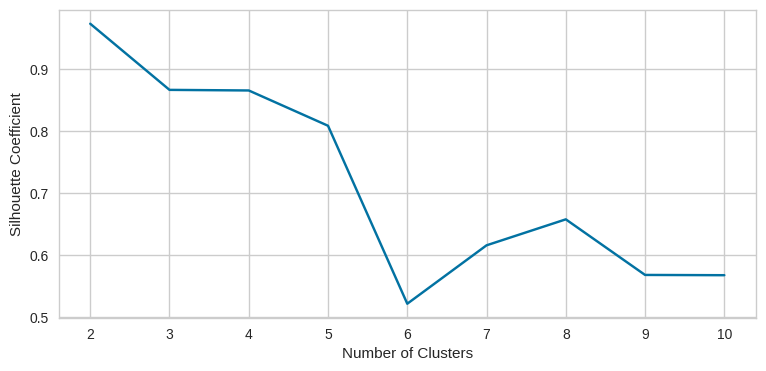

In [105]:
plt.figure(figsize=(9,4))
plt.style.use('seaborn-whitegrid')
plt.plot(range(2,11), silhouette_coef)
plt.xticks(range(2, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

In [106]:
# k-means 모델 설정
kmeans_model_3 = KMeans(
    init="k-means++",
    n_clusters=6,
    n_init=10,
    max_iter=300,
    random_state=37)

# 군집 결합
purchase_info['cluster1'] = kmeans_model_3.fit_predict(df_standard)
purchase_info.head()

,customer_no,가구/인테리어,건강식품,남성의류,대형가전,레저/스포츠,레포츠패션,반려용품,뷰티,상품권,...,여성의류,여행,일반식품,주방가전,주방용품,침구,캐쥬얼,키즈/유아동,패션잡화,cluster1
0,74,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,113,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,596,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,652,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1152,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [107]:
# 각 군집별 비율 확인하기
purchase_info.groupby('cluster1').customer_no.count()/purchase_info.shape[0]

cluster1
0    0.969553
1    0.000073
2    0.002123
3    0.000732
4    0.003989
5    0.023531
Name: customer_no, dtype: float64

In [108]:
# 6개 클러스터 EDA
purchase_info.groupby('cluster1').agg(
    uu = ('customer_no','count'),
    가구인테리어 = ('가구/인테리어','mean'),
    건강식품 = ('건강식품','mean'),
    남성의류 = ('남성의류','mean'),
    대형가전 = ('대형가전','mean'),
    레저스포츠 = ('레저/스포츠','mean'),
    레포츠패션 = ('레포츠패션','mean'),
    반려용품 = ('반려용품','mean'),
    뷰티 = ('뷰티','mean'),
    상품권 = ('상품권','mean'),
    생활가전 = ('생활가전','mean'),
    생활용품 = ('생활용품','mean'),
    언더웨어 = ('언더웨어','mean'),
    여성의류 = ('여성의류','mean'),
    여행 = ('여행','mean'),
    일반식품 = ('일반식품','mean'),
    주방가전 = ('주방가전','mean'),
    주방용품 = ('주방용품','mean'),
    침구 = ('침구','mean'),
    캐쥬얼 = ('캐쥬얼','mean'),
    키즈유아동 = ('키즈/유아동','mean'),
    패션잡화 = ('패션잡화','mean')
)

,uu,가구인테리어,건강식품,남성의류,대형가전,레저스포츠,레포츠패션,반려용품,뷰티,상품권,...,언더웨어,여성의류,여행,일반식품,주방가전,주방용품,침구,캐쥬얼,키즈유아동,패션잡화
cluster1,,,,,,,,,,,,,,,,,,,,,
0,26494,0.005095,0.079716,0.004605,0.100400,0.010984,0.016004,0.002869,0.033517,0.020344,...,0.178833,0.016004,0.0,2.085680,0.00585,0.020080,0.007587,0.002227,0.000038,0.051483
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,58,0.000000,0.000000,0.000000,5.896552,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,15.87931,0.000000,0.000000,0.000000,0.000000,0.000000
3,20,0.000000,0.000000,0.000000,73.600000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.10000,0.000000,0.000000,0.000000,0.000000,0.000000
4,109,0.009174,0.247706,0.018349,0.000000,0.045872,0.009174,0.000000,0.119266,0.000000,...,0.256881,0.064220,0.0,2.256881,0.00000,2.458716,0.027523,0.000000,0.009174,0.045872
5,643,0.001555,0.021773,0.000000,0.001555,0.001555,0.001555,0.000000,0.018663,0.000000,...,0.029549,0.003110,0.0,0.318818,0.00000,0.004666,0.000000,0.000000,1.654743,0.018663


In [109]:
cluster_df = pd.merge(mobile_df, purchase_info[['customer_no', 'cluster1']], on = 'customer_no', how='inner')
cluster_df.head()

,customer_no,age,gender,order_no,order_date,channel,item_category,item_code,item_name,price,qty,order_amount,discount_amount,paid_amount,가입연월,할인율,order_month,cluster1
0,6102337,38.0,여성,1179298,2021-04-28,Mobile,일반식품,320105541,생수,5700,2,11400,0,11400,2020-01,0.0,2021-04,0
1,6102337,38.0,여성,2763580,2021-03-01,Mobile,일반식품,320105541,생수,6000,1,6000,0,6000,2020-01,0.0,2021-03,0
2,6102337,38.0,여성,6007730,2021-04-05,Mobile,일반식품,320105541,생수,6000,1,6000,300,5700,2020-01,5.0,2021-04,0
3,7045198,47.0,여성,1146588,2021-02-08,Mobile,일반식품,321658904,떡,21000,1,21000,1050,19950,2019-09,5.0,2021-02,0
4,7045198,47.0,여성,0628406,2021-05-14,Mobile,일반식품,322670882,사이다,17000,1,17000,850,16150,2019-09,5.0,2021-05,0


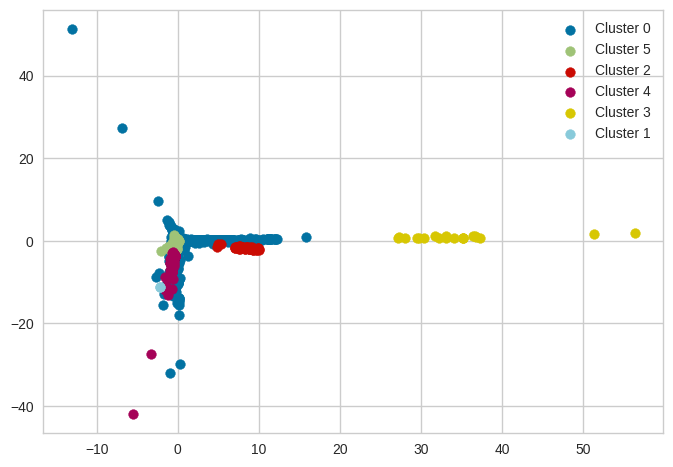

In [110]:
from sklearn.decomposition import PCA
X = df_standard
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = purchase_info['cluster1']

for i in purchase_info["cluster1"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1], label=f'Cluster {i}')  # 각 클러스터에 레이블 추가

plt.legend()  # 범례 추가
plt.show()

In [111]:
# 카테고리별 구매 현황
## 카테고리별 요약
item_category_summary = cluster_df.groupby(['cluster1', 'item_category'])['order_no'].nunique().reset_index()
item_category_summary.head()

,cluster1,item_category,order_no
0,0,가구/인테리어,135
1,0,건강식품,2112
2,0,남성의류,122
3,0,대형가전,2660
4,0,레저/스포츠,291


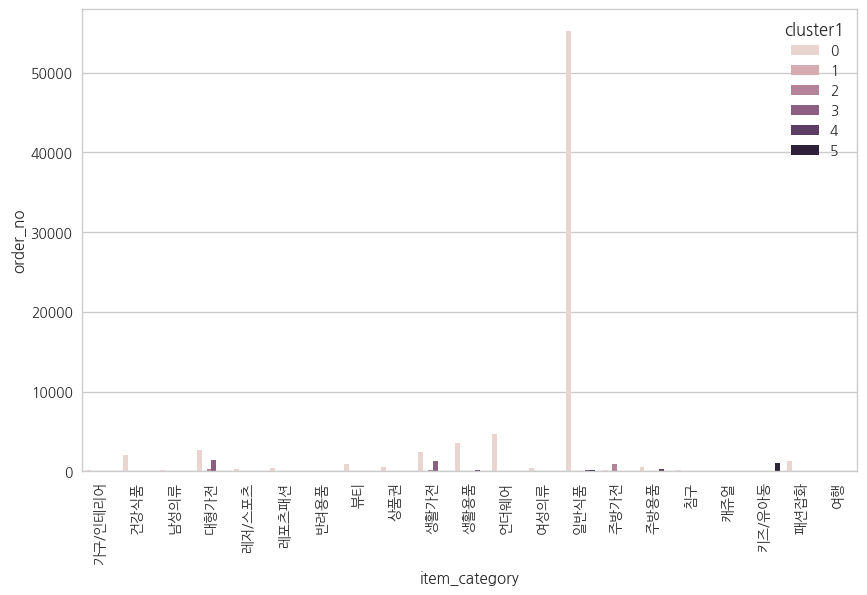

In [112]:
# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))

# seaborn을 사용한 방법
sns.barplot(x='item_category', y='order_no', hue='cluster1', data=item_category_summary, dodge=True)

plt.xticks(rotation=90)
plt.show()

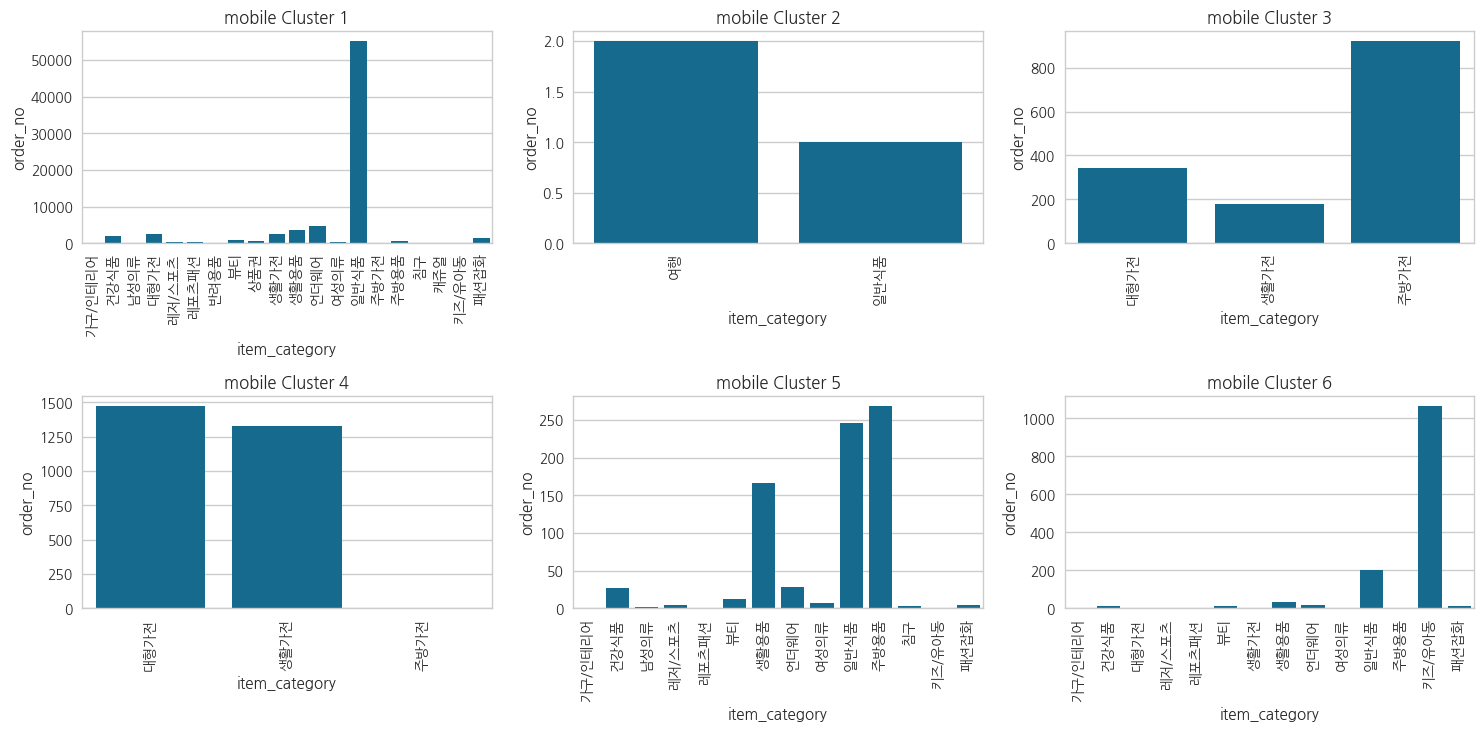

In [113]:
# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# subplot을 생성하고 각 cluster에 대한 bar plot을 그립니다.
plt.figure(figsize=(15, 10))

# 각 cluster에 대한 subplot을 생성합니다.
for cluster_num in item_category_summary['cluster1'].unique():
    plt.subplot(3, 3, cluster_num + 1)  # 1행 2열의 subplot 중 현재 cluster에 해당하는 subplot 선택

    # 해당 cluster에 해당하는 데이터만 추출하여 bar plot을 그립니다.
    sns.barplot(x='item_category', y='order_no', data=item_category_summary[item_category_summary['cluster1'] == cluster_num], dodge=True)

    # 각 subplot에 제목 추가
    plt.title(f'mobile Cluster {cluster_num+1}')

    # x축 라벨 회전
    plt.xticks(rotation=90)

plt.tight_layout()  # subplot 간 간격 조절
plt.show()

#### 할인 여부에 따른 컬럼 생성

In [114]:
cluster_df['dis'] = np.where(cluster_df['할인율'] == 0, 0, 1)

### 집단 분리

In [115]:
cluster_1 = cluster_df[cluster_df['cluster1']==0]
cluster_2 = cluster_df[cluster_df['cluster1']==1]
cluster_3 = cluster_df[cluster_df['cluster1']==2]
cluster_4 = cluster_df[cluster_df['cluster1']==3]
cluster_5 = cluster_df[cluster_df['cluster1']==4]
cluster_6 = cluster_df[cluster_df['cluster1']==5]

### 집단별 구매 품목 파악

In [116]:
cluster_1['item_name'].value_counts().head(10)

item_name
생수            39363
드로즈            3277
기타 간편/즉석식품     2374
건강음료           1173
탄산수            1153
골드바/코인         1091
농축액             895
핸디형청소기          891
드럼세탁기           727
기타 반찬류          655
Name: count, dtype: int64

In [117]:
cluster_1['age'].value_counts().head(20)

age
41.0    3361
40.0    3215
39.0    3008
42.0    2858
43.0    2715
37.0    2654
38.0    2647
44.0    2581
35.0    2575
48.0    2516
45.0    2373
46.0    2306
36.0    2277
47.0    2264
50.0    2084
49.0    2067
34.0    1924
51.0    1899
33.0    1835
52.0    1747
Name: count, dtype: int64

In [118]:
cluster_2['item_name'].value_counts()

item_name
코펠/식기    2
떡        1
Name: count, dtype: int64

In [119]:
cluster_2['gender'].value_counts()

gender
여성    2
불명    1
Name: count, dtype: int64

In [120]:
cluster_3['item_name'].value_counts()

item_name
IH압력밥솥         664
일반압력밥솥         309
전자레인지          208
공기청정기          128
핸디형청소기          49
냉장고/냉동고         41
미니/업소용 전기밥솥     23
일반세탁기            7
전기오븐             4
면도기              3
무선청소기            2
제습기              2
진공청소기            1
Name: count, dtype: int64

In [121]:
cluster_3['age'].value_counts().head(20)

age
31.0    284
37.0    231
38.0    175
34.0    152
33.0    150
36.0    140
30.0    102
35.0     51
58.0     28
59.0     26
32.0     25
43.0     24
29.0     23
64.0     17
48.0     13
Name: count, dtype: int64

In [122]:
cluster_3['gender'].value_counts()

gender
남성    822
여성    578
불명     41
Name: count, dtype: int64

In [123]:
cluster_4['item_name'].value_counts()

item_name
일반세탁기          707
냉장고/냉동고        657
드럼세탁기          643
LED TV         448
의류건조기           66
벽걸이/액자형 에어컨     66
스탠드형 김치냉장고      65
양문형 냉장고         62
식기세척기           24
스팀/광파오븐         21
스타일러            15
2구 이상 전기레인지     14
뚜껑식 김치냉장고       12
와인냉장고            4
인덕션 렌지           1
Name: count, dtype: int64

In [124]:
cluster_4['age'].value_counts().head(20)

age
37.0    931
36.0    332
30.0    271
35.0    269
39.0    246
28.0    239
67.0    137
69.0    133
31.0    129
29.0    118
Name: count, dtype: int64

In [125]:
cluster_4['gender'].value_counts()

gender
남성    1759
여성    1046
Name: count, dtype: int64

In [126]:
cluster_5['item_name'].value_counts().head(20)

item_name
체중계             85
생수              73
비닐백/지퍼백/호일/랩    60
기타              49
물병/물통           30
주방장갑            28
후라이팬세트          25
기타 간편/즉석식품      24
생리대             19
기타 반찬류          13
도마              13
드로즈             12
샴푸/비누/핸드워시      11
팩/마스크           11
홈세트             10
즉석밥             10
도너츠              9
농축액              8
수세미/행주           8
제빵소도구            7
Name: count, dtype: int64

In [127]:
cluster_5['age'].value_counts().head(20)

age
78.0    89
34.0    85
48.0    59
43.0    49
50.0    41
49.0    41
52.0    35
61.0    35
57.0    31
55.0    29
54.0    28
47.0    22
69.0    19
44.0    19
40.0    19
42.0    18
21.0    16
68.0    15
51.0    15
46.0    14
Name: count, dtype: int64

In [128]:
cluster_5['gender'].value_counts()

gender
여성    582
남성    195
불명     53
Name: count, dtype: int64

In [129]:
cluster_6['item_name'].value_counts()

item_name
이유식       356
분유        338
기저귀       149
물티슈       117
생수         74
         ... 
화장지         1
물놀이용품       1
타트체리주스      1
홈세트         1
구두/단화       1
Name: count, Length: 141, dtype: int64

In [130]:
cluster_6['qty'].value_counts()

qty
1     1094
2      224
3       41
4       15
5       13
6        7
10       4
14       1
9        1
8        1
Name: count, dtype: int64

In [131]:
cluster_6['age'].value_counts().head(20)

age
37.0    114
40.0    110
39.0     96
36.0     95
42.0     78
41.0     78
43.0     75
35.0     72
38.0     72
33.0     68
32.0     63
45.0     52
31.0     51
46.0     50
34.0     44
49.0     35
55.0     29
47.0     25
44.0     23
29.0     19
Name: count, dtype: int64

### t검정으로 할인 여부와 결제 금액 차이 파악

In [132]:
# 'dis'가 0인 그룹과 1인 그룹으로 데이터를 분리
group_0 = cluster_1[cluster_1['dis'] == 0]['order_amount']
group_1 = cluster_1[cluster_1['dis'] == 1]['order_amount']

# 독립 표본 T-검정 수행
t_stat, p_value = ttest_ind(group_0, group_1)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -69.72699645679732, P-value: 0.0


In [133]:
# 'dis'가 0인 그룹과 1인 그룹으로 데이터를 분리
group_0 = cluster_2[cluster_2['dis'] == 0]['order_amount']
group_1 = cluster_2[cluster_2['dis'] == 1]['order_amount']

# 독립 표본 T-검정 수행
t_stat, p_value = ttest_ind(group_0, group_1)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: nan, P-value: nan


In [134]:
# 'dis'가 0인 그룹과 1인 그룹으로 데이터를 분리
group_0 = cluster_3[cluster_3['dis'] == 0]['qty']
group_1 = cluster_3[cluster_3['dis'] == 1]['qty']

# 독립 표본 T-검정 수행
t_stat, p_value = ttest_ind(group_0, group_1)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -0.4019931686196325, P-value: 0.6877487518960088


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [135]:
# 'dis'가 0인 그룹과 1인 그룹으로 데이터를 분리
group_0 = cluster_4[cluster_4['dis'] == 0]['order_amount']
group_1 = cluster_4[cluster_4['dis'] == 1]['order_amount']

# 독립 표본 T-검정 수행
t_stat, p_value = ttest_ind(group_0, group_1)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: nan, P-value: nan


In [136]:
cluster_4[cluster_4['dis'] == 0].value_counts()

Series([], Name: count, dtype: int64)

In [137]:
# 'dis'가 0인 그룹과 1인 그룹으로 데이터를 분리
group_0 = cluster_5[cluster_5['dis'] == 0]['order_amount']
group_1 = cluster_5[cluster_5['dis'] == 1]['order_amount']

# 독립 표본 T-검정 수행
t_stat, p_value = ttest_ind(group_0, group_1)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -6.094641566462793, P-value: 1.6797531120918921e-09


In [138]:
# 'dis'가 0인 그룹과 1인 그룹으로 데이터를 분리
group_0 = cluster_6[cluster_6['dis'] == 0]['order_amount']
group_1 = cluster_6[cluster_6['dis'] == 1]['order_amount']

# 독립 표본 T-검정 수행
t_stat, p_value = ttest_ind(group_0, group_1)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -3.925197048525873, P-value: 9.087176523939685e-05


### 집단과 할인율(회귀모델)

In [139]:
cluster_1['order_amount'].sort_values()

38005         150
54102         150
38010         150
81584         150
43676         150
           ...   
63554    11088000
63108    13860000
54552    14754000
54547    18442500
63556    36036000
Name: order_amount, Length: 77922, dtype: int64

In [156]:
from sklearn.preprocessing import StandardScaler
# 데이터 준비
new_df = cluster_1

# 날짜별, 카테고리별로 매출액과 할인액 합계 계산
df_grouped = new_df.groupby(['order_date', 'item_category']).agg({
    'order_amount': 'sum',
    'discount_amount': 'sum',
    'age': 'mean',
    'price': 'mean',
    'qty': 'sum'
}).reset_index()

var1 = df_grouped[['discount_amount','age','price','qty']]
var2 = df_grouped['order_amount']

# 독립 변수 정규화
scaler = StandardScaler()
var1_scaled = scaler.fit_transform(var1)

# 데이터프레임을 생성하고 열 이름을 지정
var1_scaled_df = pd.DataFrame(var1_scaled, columns=['discount_amount', 'age', 'price', 'qty'])

# 정규화된 데이터에 상수항 추가
X_scaled = sm.add_constant(var1_scaled_df)

# 종속 변수 정규화
Y = scaler.fit_transform(var2.values.reshape(-1, 1))

# 선형 회귀 모델 적합
model = sm.OLS(Y, X_scaled).fit()

# 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     2724.
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        11:31:54   Log-Likelihood:                -1328.5
No. Observations:                2379   AIC:                             2667.
Df Residuals:                    2374   BIC:                             2696.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.283e-18      0.009  -4.

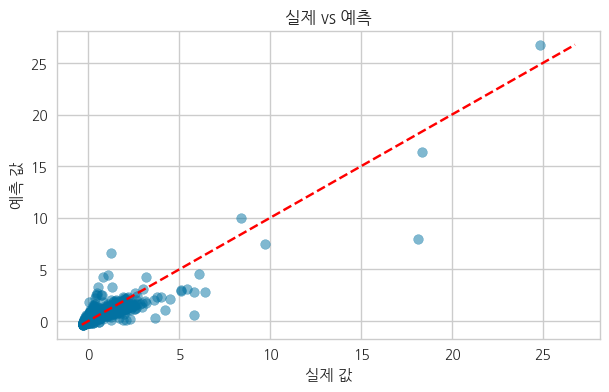

In [142]:
# 예측 값 계산
Y_pred = model.predict(X_scaled)
# 실제 값과 예측 값의 산점도
plt.figure(figsize=(7, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 vs 예측')

# 완벽한 예측을 나타내는 대각선 추가
max_val = max(Y.max(), Y_pred.max())
min_val = min(Y.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()


In [143]:
cluster_3['qty'].value_counts()

qty
1    1395
2      34
3       8
4       4
Name: count, dtype: int64

In [155]:
# 데이터 준비
new_df = cluster_3

# 날짜별, 카테고리별로 매출액과 할인액 합계 계산
df_grouped = new_df.groupby(['order_date', 'item_category']).agg({
    'order_amount': 'sum',
    'discount_amount': 'sum',
    'age': 'mean',
    'price': 'mean',
    'qty': 'sum'
}).reset_index()

var1 = df_grouped[['discount_amount','age','price','qty']]
var2 = df_grouped['order_amount']

# 독립 변수 정규화
scaler = StandardScaler()
var1_scaled = scaler.fit_transform(var1)

# 데이터프레임을 생성하고 열 이름을 지정
var1_scaled_df = pd.DataFrame(var1_scaled, columns=['discount_amount', 'age', 'price', 'qty'])

# 정규화된 데이터에 상수항 추가
X_scaled = sm.add_constant(var1_scaled_df)

# 종속 변수 정규화
Y = scaler.fit_transform(var2.values.reshape(-1, 1))

# 선형 회귀 모델 적합
model = sm.OLS(Y, X_scaled).fit()

# 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1200.
Date:                Thu, 02 May 2024   Prob (F-statistic):          1.40e-136
Time:                        11:31:42   Log-Likelihood:                 40.263
No. Observations:                 201   AIC:                            -70.53
Df Residuals:                     196   BIC:                            -54.01
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.142e-16      0.014   8.

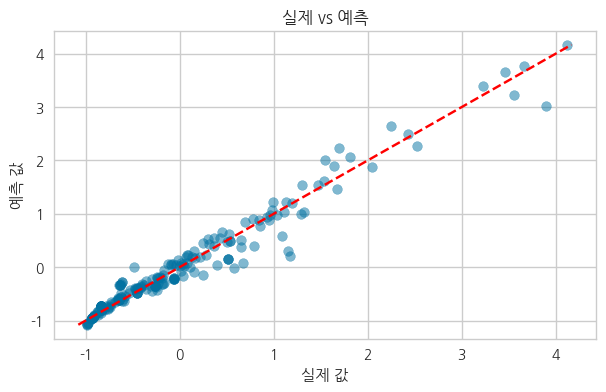

In [145]:
# 예측 값 계산
Y_pred = model.predict(X_scaled)
# 실제 값과 예측 값의 산점도
plt.figure(figsize=(7, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 vs 예측')

# 완벽한 예측을 나타내는 대각선 추가
max_val = max(Y.max(), Y_pred.max())
min_val = min(Y.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()


In [152]:
# 데이터 준비
new_df = cluster_4

# 날짜별, 카테고리별로 매출액과 할인액 합계 계산
df_grouped = new_df.groupby(['order_date', 'item_category']).agg({
    'order_amount': 'sum',
    'discount_amount': 'sum',
    'age': 'mean',
    'price': 'mean',
    'qty': 'sum'
}).reset_index()

var1 = df_grouped[['discount_amount','age','price','qty']]
var2 = df_grouped['order_amount']

# 독립 변수 정규화
scaler = StandardScaler()
var1_scaled = scaler.fit_transform(var1)

# 데이터프레임을 생성하고 열 이름을 지정
var1_scaled_df = pd.DataFrame(var1_scaled, columns=['discount_amount', 'age', 'price', 'qty'])

# 정규화된 데이터에 상수항 추가
X_scaled = sm.add_constant(var1_scaled_df)

# 종속 변수 정규화
Y = scaler.fit_transform(var2.values.reshape(-1, 1))

# 선형 회귀 모델 적합
model = sm.OLS(Y, X_scaled).fit()

# 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1374.
Date:                Thu, 02 May 2024   Prob (F-statistic):          9.52e-170
Time:                        11:31:20   Log-Likelihood:                 37.136
No. Observations:                 257   AIC:                            -64.27
Df Residuals:                     252   BIC:                            -46.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.716e-17      0.013   2.

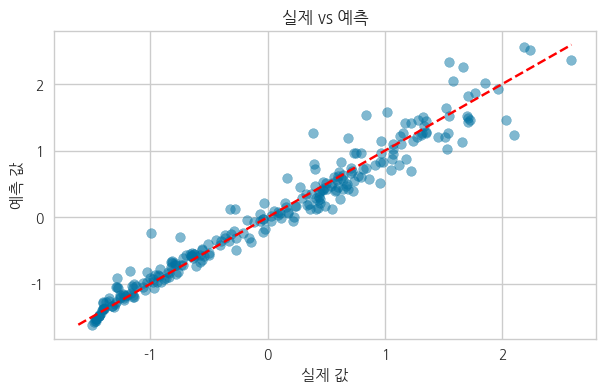

In [147]:
# 예측 값 계산
Y_pred = model.predict(X_scaled)
# 실제 값과 예측 값의 산점도
plt.figure(figsize=(7, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 vs 예측')

# 완벽한 예측을 나타내는 대각선 추가
max_val = max(Y.max(), Y_pred.max())
min_val = min(Y.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()


In [153]:
# 데이터 준비
new_df = cluster_5

# 날짜별, 카테고리별로 매출액과 할인액 합계 계산
df_grouped = new_df.groupby(['order_date', 'item_category']).agg({
    'order_amount': 'sum',
    'discount_amount': 'sum',
    'age': 'mean',
    'price': 'mean',
    'qty': 'sum'
}).reset_index()

var1 = df_grouped[['discount_amount','age','price','qty']]
var2 = df_grouped['order_amount']

# 독립 변수 정규화
scaler = StandardScaler()
var1_scaled = scaler.fit_transform(var1)

# 데이터프레임을 생성하고 열 이름을 지정
var1_scaled_df = pd.DataFrame(var1_scaled, columns=['discount_amount', 'age', 'price', 'qty'])

# 정규화된 데이터에 상수항 추가
X_scaled = sm.add_constant(var1_scaled_df)

# 종속 변수 정규화
Y = scaler.fit_transform(var2.values.reshape(-1, 1))

# 선형 회귀 모델 적합
model = sm.OLS(Y, X_scaled).fit()

# 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     299.0
Date:                Thu, 02 May 2024   Prob (F-statistic):          1.30e-109
Time:                        11:31:30   Log-Likelihood:                -227.31
No. Observations:                 343   AIC:                             464.6
Df Residuals:                     338   BIC:                             483.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -3.35e-17      0.026  -1.

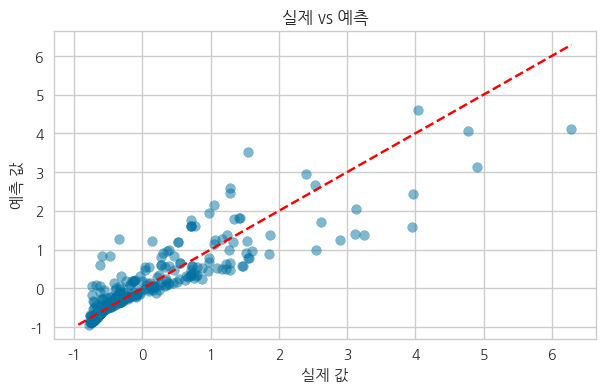

In [149]:
# 예측 값 계산
Y_pred = model.predict(X_scaled)
# 실제 값과 예측 값의 산점도
plt.figure(figsize=(7, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 vs 예측')

# 완벽한 예측을 나타내는 대각선 추가
max_val = max(Y.max(), Y_pred.max())
min_val = min(Y.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()


In [154]:
# 데이터 준비
new_df = cluster_6[cluster_6['할인율']!=0]

df_grouped = new_df.groupby(['order_date', 'item_category']).agg({
    'order_amount': 'sum',
    'discount_amount': 'sum',
    'age': 'mean',
    'price': 'mean',
    'qty': 'sum'
}).reset_index()

var1 = df_grouped[['discount_amount','age','price','qty']]
var2 = df_grouped['order_amount']

# 독립 변수 정규화
scaler = StandardScaler()
var1_scaled = scaler.fit_transform(var1)

# 데이터프레임을 생성하고 열 이름을 지정
var1_scaled_df = pd.DataFrame(var1_scaled, columns=['discount_amount', 'age', 'price', 'qty'])

# 정규화된 데이터에 상수항 추가
X_scaled = sm.add_constant(var1_scaled_df)

# 종속 변수 정규화
Y = scaler.fit_transform(var2.values.reshape(-1, 1))

# 선형 회귀 모델 적합
model = sm.OLS(Y, X_scaled).fit()

# 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     8398.
Date:                Thu, 02 May 2024   Prob (F-statistic):          7.88e-272
Time:                        11:31:35   Log-Likelihood:                 268.11
No. Observations:                 263   AIC:                            -526.2
Df Residuals:                     258   BIC:                            -508.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.735e-18      0.005  -3.

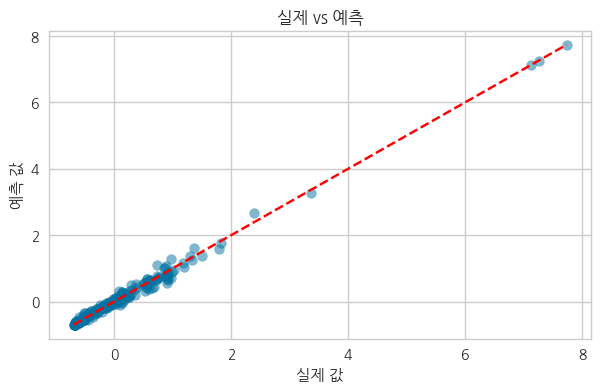

In [151]:
# 예측 값 계산
Y_pred = model.predict(X_scaled)
# 실제 값과 예측 값의 산점도
plt.figure(figsize=(7, 4))
plt.scatter(Y, Y_pred, alpha=0.5)
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('실제 vs 예측')

# 완벽한 예측을 나타내는 대각선 추가
max_val = max(Y.max(), Y_pred.max())
min_val = min(Y.min(), Y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()
